In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

In [135]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

time   cpu_temp  inlet_temp    it_power    fan_speed
0  4718  55.766525   22.468243  177.345436  3929.161963
1  4719  55.608490   22.468213  177.350546  3929.225715
2  4720  55.446706   22.468188  177.362315  3929.311931
3  4721  55.238044   22.468170  177.380743  3929.420613
4  4721  54.960208   22.468170  177.380743  3929.420613

In [136]:
combined_df.to_csv("../data/combined_df.csv", index=False)

df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [137]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [138]:
def prepare_data(scaled_df, seq_length=8, k_step=24):
    """
    Prepares the data for the TimeSeriesModel, creating sequences of historical
    data and future exogenous variables, and splitting the data into training and testing
    sets.

    Args:
        scaled_df (pd.DataFrame): Scaled DataFrame containing all features.
        seq_length (int): Length of historical time series sequences.
        k_step (int): Number of future steps to predict.

    Returns:
       train_loader (DataLoader): DataLoader for training data.
       test_loader (DataLoader): DataLoader for testing data.
       outputs: Tensor of all the labels
       split_index: The index to split the dataset to train/test
    """

    # Input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'  # The variable we predict


    # Create sequences
    features = []
    exogenous = []
    outputs = []

    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1) # Reshape to make exogenous of form (num_sequences, k, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1) # Reshape to make outputs of form (num_sequences, k, 1)


    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)
    
    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)


    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [140]:
class TimeSeriesModel(nn.Module):
    def __init__(self, num_features_history, hidden_dim, num_features_future, future_dim, fusion_dim, k):
        super(TimeSeriesModel, self).__init__()

        # --- Time Series History Processing Block ---
        self.history_embedding = nn.Linear(num_features_history, hidden_dim)
        self.history_attention = nn.MultiheadAttention(hidden_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
        self.history_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.history_pooling = nn.AdaptiveAvgPool1d(1) # Added to reduce shape to (1, hidden_dim)
        
        # --- Time Series Future Processing Block ---
        self.future_embedding = nn.Linear(num_features_future, future_dim)
        self.future_lstm = nn.LSTM(future_dim, future_dim, batch_first=True)
        self.future_attention = nn.MultiheadAttention(future_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
        
        # --- Fusion Layer ---
        self.repeat_layer = lambda x,k: x.repeat(1,k,1)
        self.fusion_dense1 = nn.Linear(hidden_dim, fusion_dim)
        self.fusion_dense2 = nn.Linear(future_dim, fusion_dim)
        self.fusion_attention = nn.MultiheadAttention(fusion_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
        self.fusion_final = nn.Linear(2 * fusion_dim, fusion_dim)

        # --- Prediction Network ---
        self.prediction_dense1 = nn.Linear(fusion_dim, fusion_dim)
        self.prediction_final = nn.Linear(fusion_dim, 1)
        
        self.k = k


    def forward(self, X_history, Y_future):
        # --- Time Series History Processing Block ---
        # Input X_history : (batch_size, m, num_features_history)
        
        batch_size = X_history.size(0)
        
        embedded_history = F.relu(self.history_embedding(X_history))  # (batch_size, m, hidden_dim)
        
        # Attention Layer
        attn_output, _ = self.history_attention(embedded_history, embedded_history, embedded_history) #(batch_size, m, hidden_dim)

        lstm_output, _ = self.history_lstm(attn_output) # (batch_size, m, hidden_dim)

        pooled_history = self.history_pooling(lstm_output.permute(0, 2, 1)).permute(0,2,1) # (batch_size, 1, hidden_dim)
        
        # --- Time Series Future Processing Block ---
        # Input Y_future : (batch_size, k, num_features_future)
        embedded_future = F.relu(self.future_embedding(Y_future)) #(batch_size, k, future_dim)
        
        future_lstm_output, _ = self.future_lstm(embedded_future) # (batch_size, k, future_dim)
        
        future_attn_output, _ = self.future_attention(future_lstm_output, future_lstm_output, future_lstm_output) # (batch_size, k, future_dim)
        
        # --- Fusion Layer ---
        
        repeated_history = self.repeat_layer(pooled_history, self.k)  #(batch_size, k, hidden_dim)
        
        
        transformed_history = F.relu(self.fusion_dense1(repeated_history)) # (batch_size, k, fusion_dim)
        transformed_future = F.relu(self.fusion_dense2(future_attn_output)) # (batch_size, k, fusion_dim)
        
        
        
        combined_inputs = torch.cat((transformed_history, transformed_future), dim=-1) # (batch_size, k, 2*fusion_dim)
        fused_output = F.relu(self.fusion_final(combined_inputs)) #(batch_size, k, fusion_dim)
        
        # --- Prediction Network ---
        
        
        dense_output = F.relu(self.prediction_dense1(fused_output))  # (batch_size, k, fusion_dim)
        predictions = self.prediction_final(dense_output)  # (batch_size, k, 1)

        return predictions

In [141]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TimeSeriesModel(nn.Module):
#     def __init__(self, num_features_history, hidden_dim, num_features_future, future_dim, fusion_dim, k):
#         super(TimeSeriesModel, self).__init__()

#         # --- Time Series History Processing Block ---
#         self.history_embedding = nn.Linear(num_features_history, hidden_dim)
#         self.history_attention = nn.MultiheadAttention(hidden_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
#         self.history_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
#         self.history_pooling = nn.AdaptiveAvgPool1d(1) # Added to reduce shape to (1, hidden_dim)
        
#         # --- Time Series Future Processing Block ---
#         self.future_embedding = nn.Linear(num_features_future, future_dim)
#         self.future_lstm = nn.LSTM(future_dim, future_dim, batch_first=True)
#         self.future_attention = nn.MultiheadAttention(future_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
        
#         # --- Fusion Layer ---
#         self.repeat_layer = lambda x,k: x.repeat(1,k,1)
#         self.fusion_dense1 = nn.Linear(hidden_dim, fusion_dim)
#         self.fusion_dense2 = nn.Linear(future_dim, fusion_dim)
#         self.fusion_attention = nn.MultiheadAttention(fusion_dim, num_heads=1) # Added MultiheadAttention instead of a custom implementation, you can also change the number of heads
#         self.fusion_final = nn.Linear(2 * fusion_dim, fusion_dim)

#         # --- Prediction Network ---
#         self.prediction_dense1 = nn.Linear(fusion_dim, fusion_dim)
#         self.prediction_final = nn.Linear(fusion_dim, 1)
        
#         self.k = k
#         self.num_features_history = num_features_history


#     def forward(self, X_history, Y_future):
#         # --- Time Series History Processing Block ---
#         # Input X_history : (batch_size, m, num_features_history)
#         batch_size, m, _ = X_history.size()

#         # average of the 2nd and 3rd past features to use as input
#         average_history_features = torch.mean(X_history[:, :, 1:3], dim =1).unsqueeze(1)
        
#         outputs = []

#         for k in range(self.k):
            
#             embedded_history = F.relu(self.history_embedding(X_history))  # (batch_size, m, hidden_dim)
            
#             # Attention Layer
#             attn_output, _ = self.history_attention(embedded_history, embedded_history, embedded_history) #(batch_size, m, hidden_dim)

#             lstm_output, _ = self.history_lstm(attn_output) # (batch_size, m, hidden_dim)

#             pooled_history = self.history_pooling(lstm_output.permute(0, 2, 1)).permute(0,2,1) # (batch_size, 1, hidden_dim)
            
#             # --- Time Series Future Processing Block ---
#             # Input Y_future : (batch_size, k, num_features_future)
#             embedded_future = F.relu(self.future_embedding(Y_future[:,k,:].unsqueeze(1))) #(batch_size, 1, future_dim)
            
#             future_lstm_output, _ = self.future_lstm(embedded_future) # (batch_size, 1, future_dim)
            
#             future_attn_output, _ = self.future_attention(future_lstm_output, future_lstm_output, future_lstm_output) # (batch_size, 1, future_dim)
            
#             # --- Fusion Layer ---
            
#             repeated_history = self.repeat_layer(pooled_history, 1)  #(batch_size, 1, hidden_dim)
            
            
#             transformed_history = F.relu(self.fusion_dense1(repeated_history)) # (batch_size, 1, fusion_dim)
#             transformed_future = F.relu(self.fusion_dense2(future_attn_output)) # (batch_size, 1, fusion_dim)
            
            
            
#             combined_inputs = torch.cat((transformed_history, transformed_future), dim=-1) # (batch_size, 1, 2*fusion_dim)
#             fused_output = F.relu(self.fusion_final(combined_inputs)) #(batch_size, 1, fusion_dim)
            
#             # --- Prediction Network ---
            
            
#             dense_output = F.relu(self.prediction_dense1(fused_output))  # (batch_size, 1, fusion_dim)
#             predictions = self.prediction_final(dense_output)  # (batch_size, 1, 1)

#             outputs.append(predictions)
#             if k < self.k - 1:
#                  # Use the predicted output as next input by adding average of past features
#                 output_expanded = predictions
#                 # print(output_expanded.shape)
#                 # print(average_history_features.shape)
#                 output_expanded = torch.cat((output_expanded, average_history_features), dim = 2)

#                 X_history = torch.cat((X_history[:, 1:], output_expanded), dim=1)


#         return torch.cat(outputs, dim=1)

In [142]:
def train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001, device='cpu'):
    """
    Trains the TimeSeriesModel.

    Args:
        model (nn.Module): The TimeSeriesModel instance.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        device (str): 'cpu' or 'cuda' to use for training.

    Returns:
        None (or you can modify to return training statistics/model checkpoint)
    """
    model.to(device) #Move the model to the device being used for training (CPU or GPU)

    criterion = nn.MSELoss()  # Mean Squared Error Loss (or any other appropriate loss)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) #Adam optimizer, you can use any optimizer that is suited for your problem

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0
        
        for batch_idx, (batch_features, batch_exogenous, batch_outputs) in enumerate(train_loader):
            batch_features = batch_features.to(device)  #Move data to the device used for training
            batch_exogenous = batch_exogenous.to(device) #Move data to the device used for training
            batch_outputs = batch_outputs.to(device)    #Move data to the device used for training

            optimizer.zero_grad()  # Clear gradients from previous steps
            predictions = model(batch_features, batch_exogenous)  # Forward pass
            loss = criterion(predictions, batch_outputs)  # Compute loss

            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step() # Update the weights

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Evaluation on test set (optional)
        model.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for batch_idx, (batch_features, batch_exogenous, batch_outputs) in enumerate(test_loader):
                batch_features = batch_features.to(device) # Move data to the device used for training
                batch_exogenous = batch_exogenous.to(device) # Move data to the device used for training
                batch_outputs = batch_outputs.to(device)   # Move data to the device used for training
                
                test_predictions = model(batch_features, batch_exogenous)
                test_loss = criterion(test_predictions, batch_outputs)

                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)

        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    print("Training complete.")
    return model

In [143]:
torch.manual_seed(42)
np.random.seed(42)

m = 15
k = 30

train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length=m, k_step=k)

In [158]:
num_features_history = 3
hidden_dim = 32
num_features_future = 1
future_dim = 32
fusion_dim = 64

model = TimeSeriesModel(num_features_history, hidden_dim, num_features_future, future_dim, fusion_dim, k)

epochs = 10
learning_rate = 0.001
device = 'cpu'

trained_model = train_model(model, train_loader, test_loader, epochs, learning_rate, device)

Epoch: 1/10, Train Loss: 0.083509, Test Loss: 0.181749
Epoch: 2/10, Train Loss: 0.042046, Test Loss: 0.016739
Epoch: 3/10, Train Loss: 0.009470, Test Loss: 0.014686
Epoch: 4/10, Train Loss: 0.007329, Test Loss: 0.014590
Epoch: 5/10, Train Loss: 0.006620, Test Loss: 0.015477
Epoch: 6/10, Train Loss: 0.006290, Test Loss: 0.014065
Epoch: 7/10, Train Loss: 0.006131, Test Loss: 0.015217
Epoch: 8/10, Train Loss: 0.005802, Test Loss: 0.016525
Epoch: 9/10, Train Loss: 0.005926, Test Loss: 0.015505
Epoch: 10/10, Train Loss: 0.006320, Test Loss: 0.017088
Training complete.


In [159]:
import os

save_path = "../models/dual_fusion_model.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ../models/dual_fusion_model.pth


In [160]:
def evaluate_model(model, test_loader, scaler, df, k_step, outputs, split_index, device='cpu'):
    """
    Evaluates the TimeSeriesModel and calculates performance metrics.

    Args:
        model (nn.Module): The trained TimeSeriesModel.
        test_loader (DataLoader): DataLoader for test data.
        scaler (MinMaxScaler): Scaler used for original data scaling
        df (pd.DataFrame): original Pandas DataFrame
        k_step (int): Number of future steps predicted.
        outputs: Tensor of all the labels
        split_index: The index at which the dataset is split to train and test
        device (str): 'cpu' or 'cuda' to use for evaluation.

    Returns:
       predictions_df (pd.DataFrame): Dataframe containing the actual and predicted values for every step in the k_step range
       test_loss (float): Test loss.
       r2_scores (List[float]): R2 score for every step in the k_step range
       rmse_scores (List[float]): RMSE score for every step in the k_step range
       average_r2 (float): Average R2 score.
       average_rmse (float): Average RMSE score.
    """
    model.to(device) # Move model to device for evaluation
    model.eval() # Sets the model to evaluation mode
    criterion = nn.MSELoss() #Initialize loss function
    test_loss = 0.0 #Initialize test_loss
    predictions = []  #Store model predictions
    actuals = [] #Store actual labels
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            batch_features = batch_features.to(device) #Move input to device
            batch_exogenous = batch_exogenous.to(device) #Move input to device
            batch_outputs = batch_outputs.to(device)    #Move labels to device
            
            batch_predictions = model(batch_features, batch_exogenous) # Forward pass to get predictions
            loss = criterion(batch_predictions, batch_outputs)   # Calculate the loss
            test_loss += loss.item()
            predictions.append(batch_predictions.cpu().numpy())  # Save predictions to numpy, and move to cpu
            actuals.append(batch_outputs.cpu().numpy())   # Save actual values to numpy and move to cpu

    test_loss /= len(test_loader) # Calculates test loss
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy array and rescale
    predictions = np.concatenate(predictions, axis=0) # Concatenate along the batches
    actuals = np.concatenate(actuals, axis=0) # Concatenate along the batches
    
    # Create a dataframe using the original dataframe index and actual values
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:,i,0]

    # Create a dataframe from predictions using the same index as the actual values
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:,i,0]
    
    #Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(predictions_df[['cpu_temp','inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:,-1]

        original_data_actual = scaler.inverse_transform(actual_df[['cpu_temp','inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values)
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:,-1]
    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")
    
    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse

In [ ]:
predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(trained_model, test_loader, scalers["cpu_temp"], combined_df, k, outputs, split_index, device)

Test Loss: 0.0171
R2 Score for Step 1: 0.7485
R2 Score for Step 2: 0.7522
R2 Score for Step 3: 0.7561
R2 Score for Step 4: 0.7607
R2 Score for Step 5: 0.7655
R2 Score for Step 6: 0.7704
R2 Score for Step 7: 0.7752
R2 Score for Step 8: 0.7796
R2 Score for Step 9: 0.7837
R2 Score for Step 10: 0.7871
R2 Score for Step 11: 0.7909
R2 Score for Step 12: 0.7958
R2 Score for Step 13: 0.7999
R2 Score for Step 14: 0.8045
R2 Score for Step 15: 0.8099
R2 Score for Step 16: 0.8152
R2 Score for Step 17: 0.8198
R2 Score for Step 18: 0.8240
R2 Score for Step 19: 0.8282
R2 Score for Step 20: 0.8324
R2 Score for Step 21: 0.8365
R2 Score for Step 22: 0.8407
R2 Score for Step 23: 0.8446
R2 Score for Step 24: 0.8481
R2 Score for Step 25: 0.8514
R2 Score for Step 26: 0.8548
R2 Score for Step 27: 0.8581
R2 Score for Step 28: 0.8606
R2 Score for Step 29: 0.8628
R2 Score for Step 30: 0.8650
Average R2 Score: 0.8107
RMSE for Step 1: 4.2765
RMSE for Step 2: 4.2508
RMSE for Step 3: 4.2267
RMSE for Step 4: 4.1962


: 

In [148]:
def plot_results(predictions_df, k_step, r2_scores):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp {i+1}', color='red')
        plt.plot(predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp {i+1}', color='blue', alpha=0.6)
        plt.xlabel('Time Step')
        plt.ylabel('CPU Temperature')
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, R2: {r2_scores[i]:.4f}')
        plt.legend()
        plt.show()

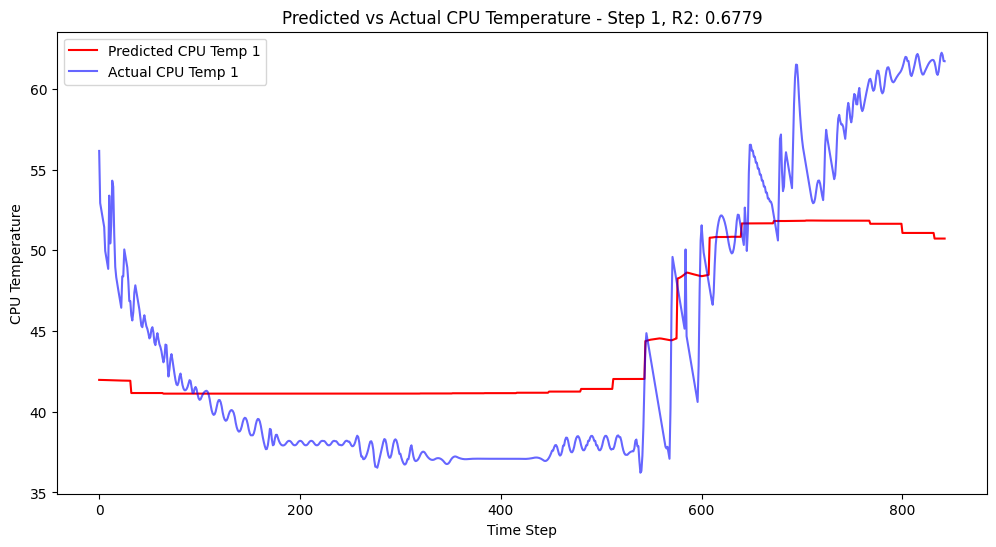

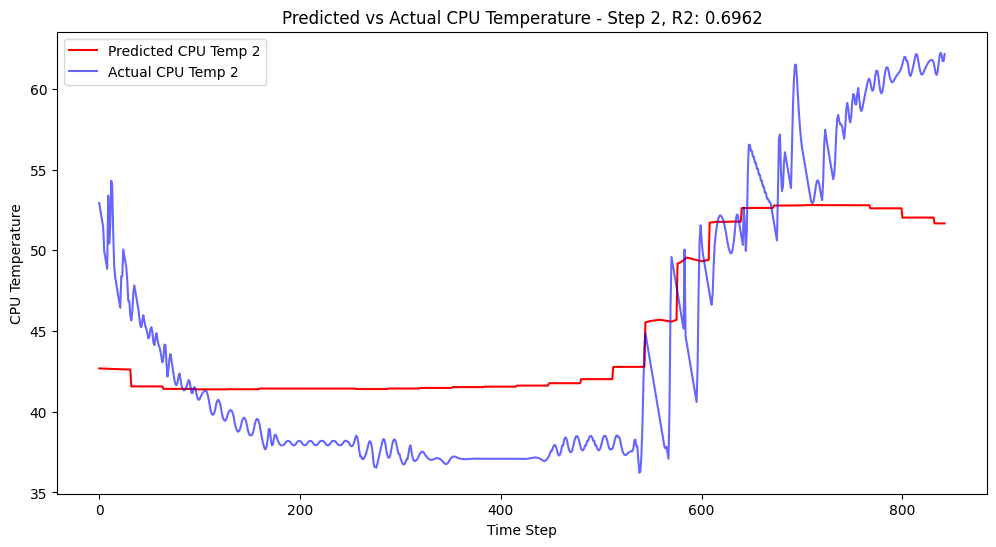

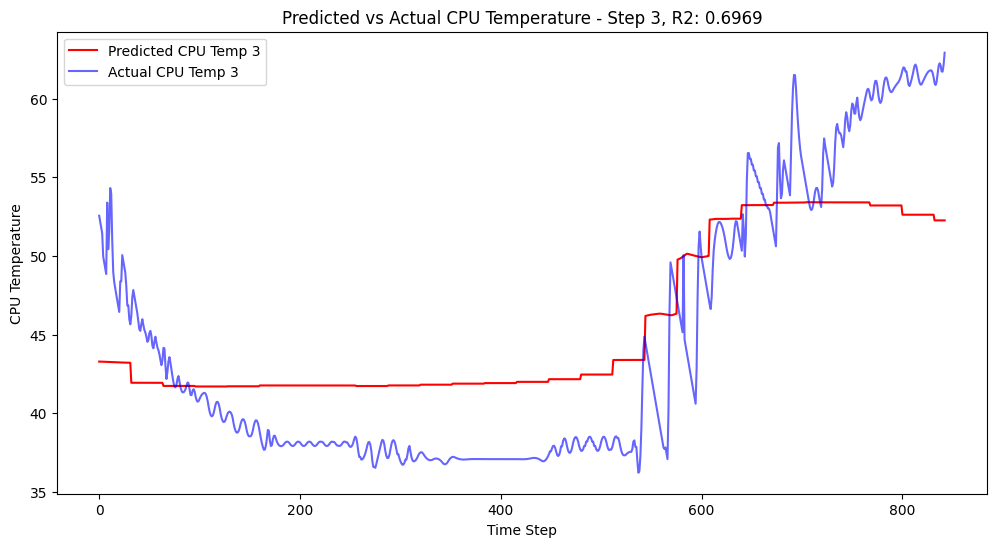

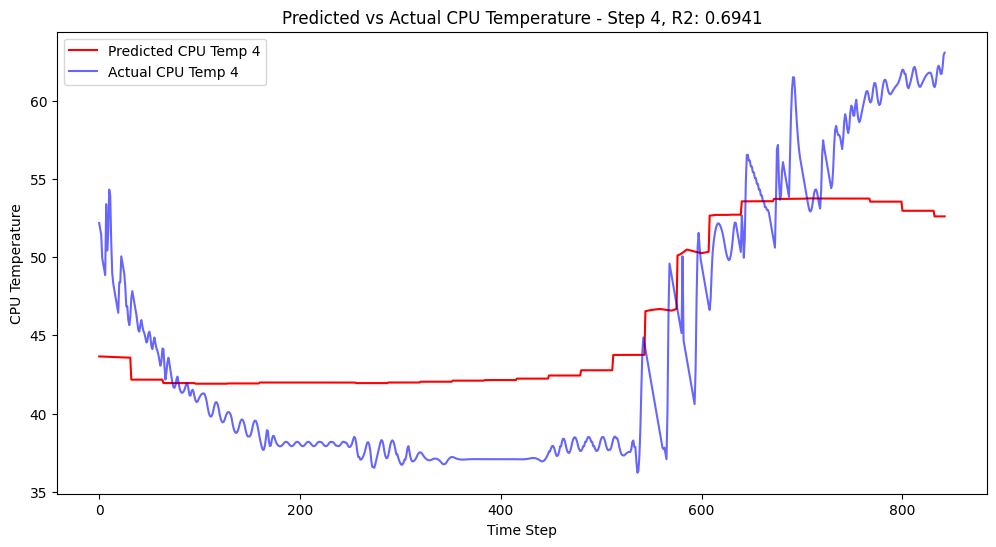

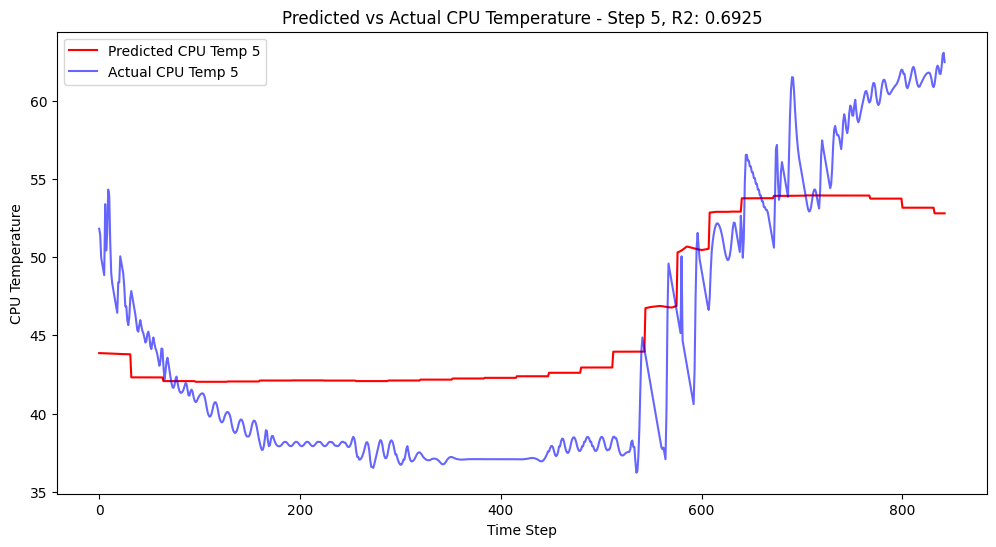

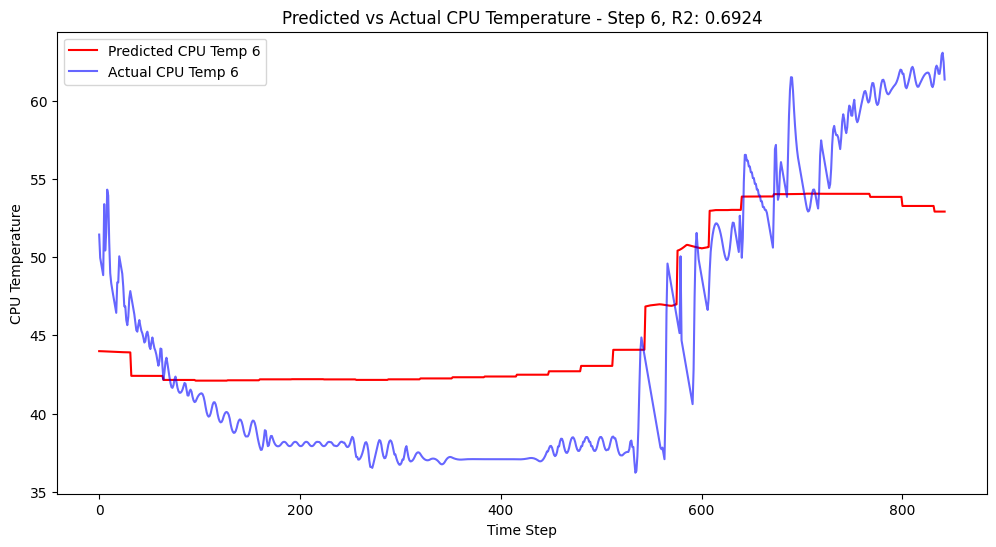

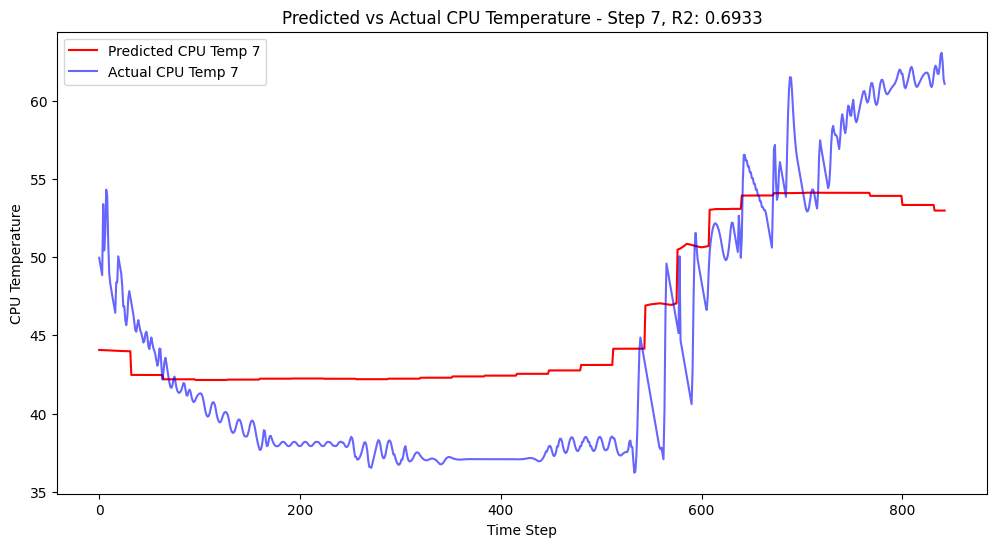

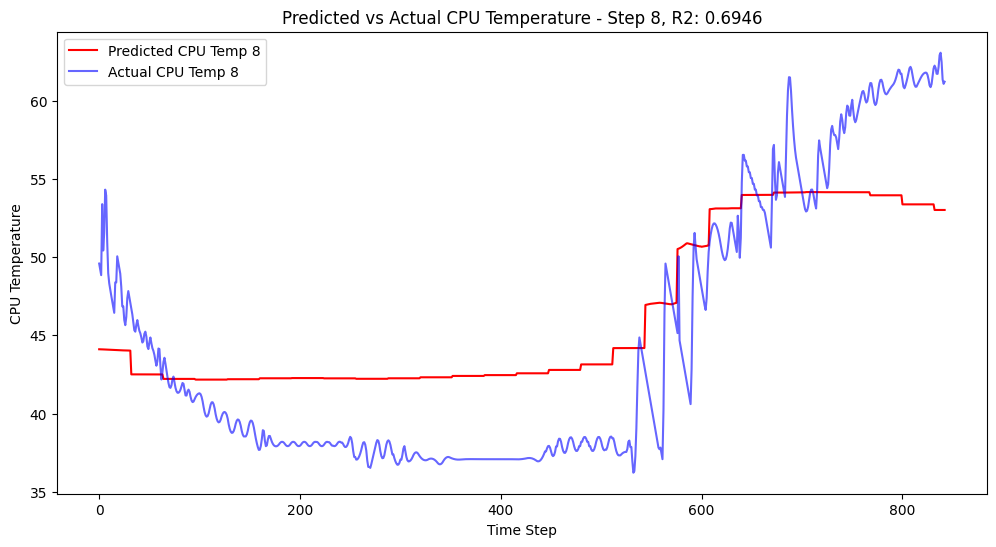

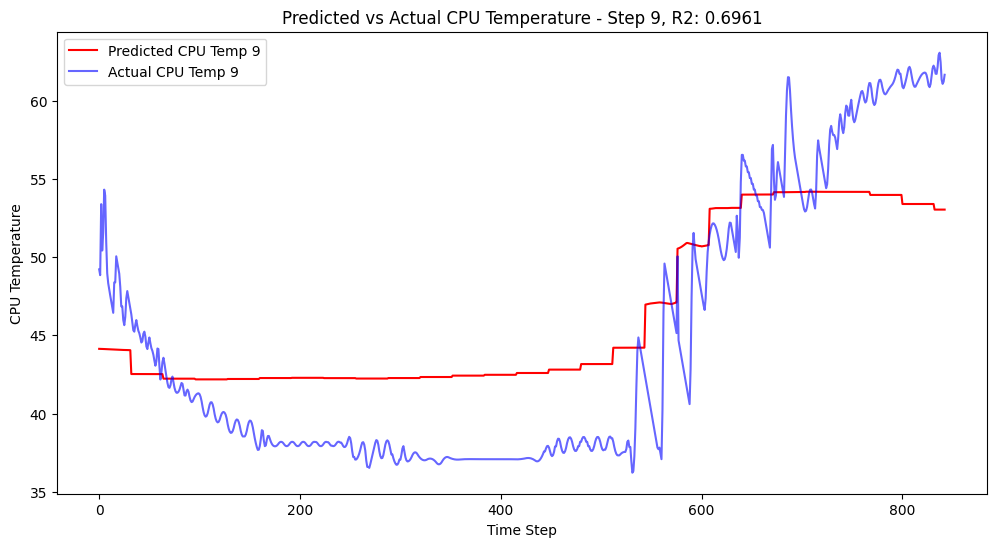

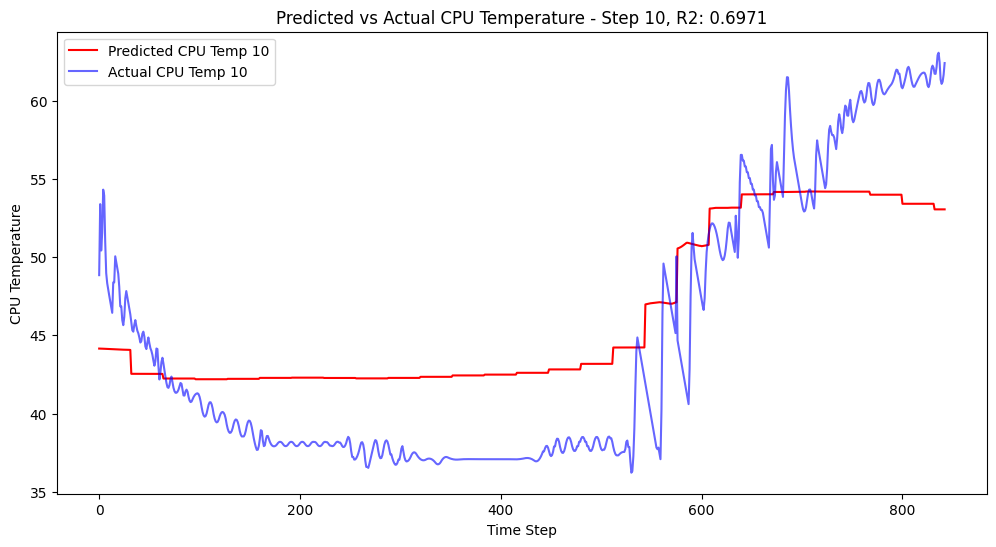

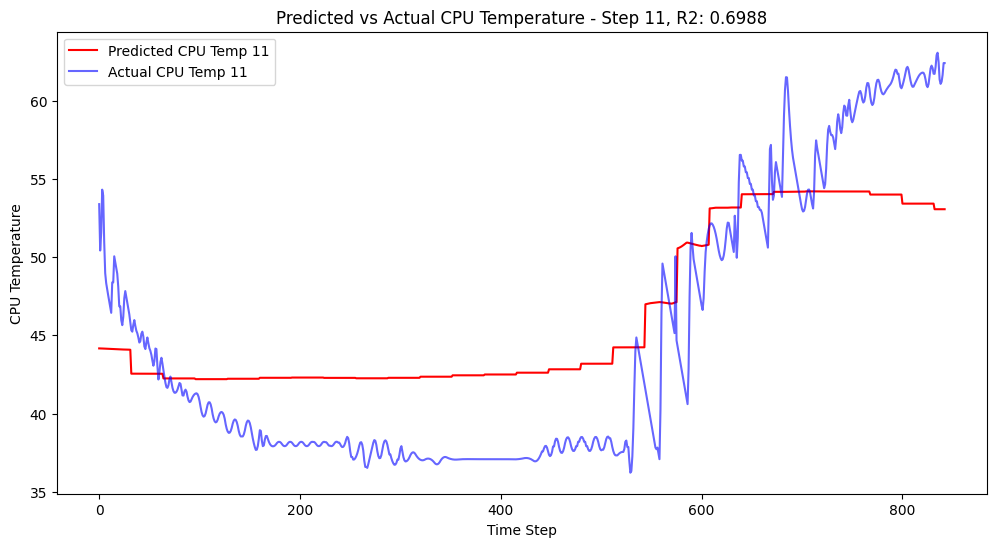

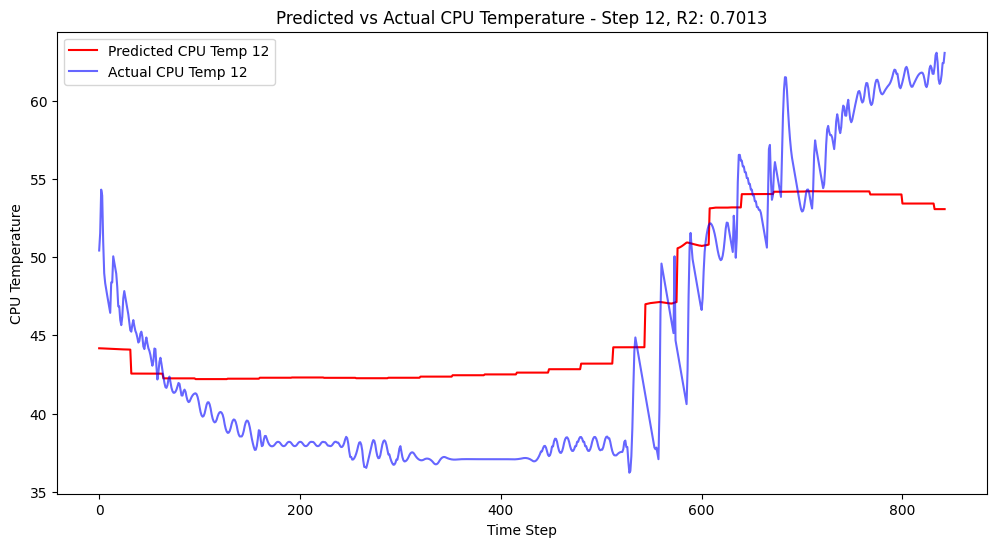

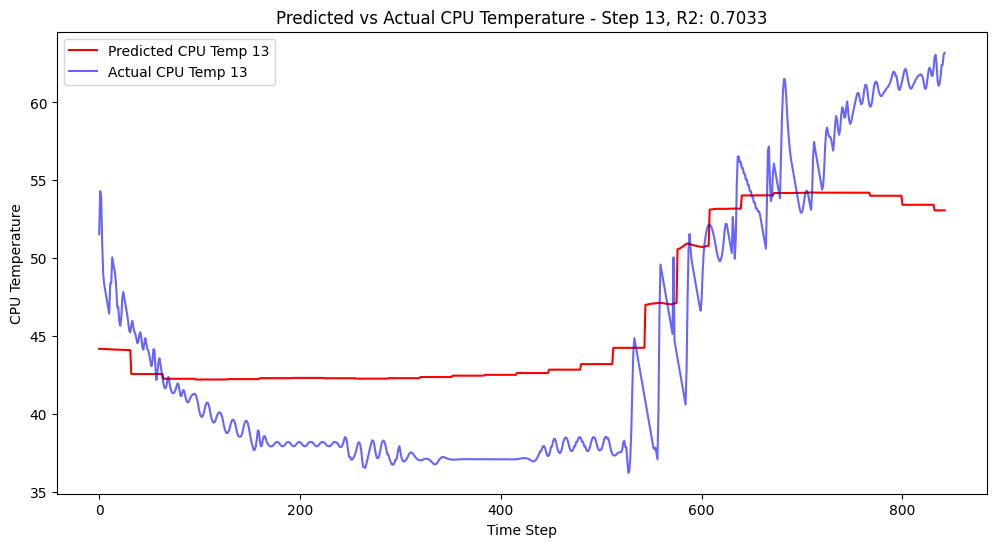

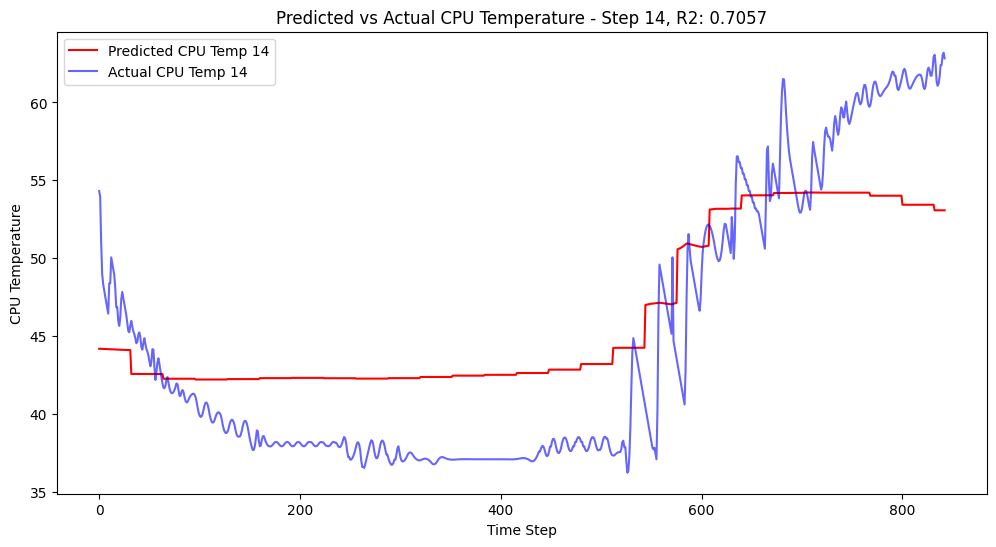

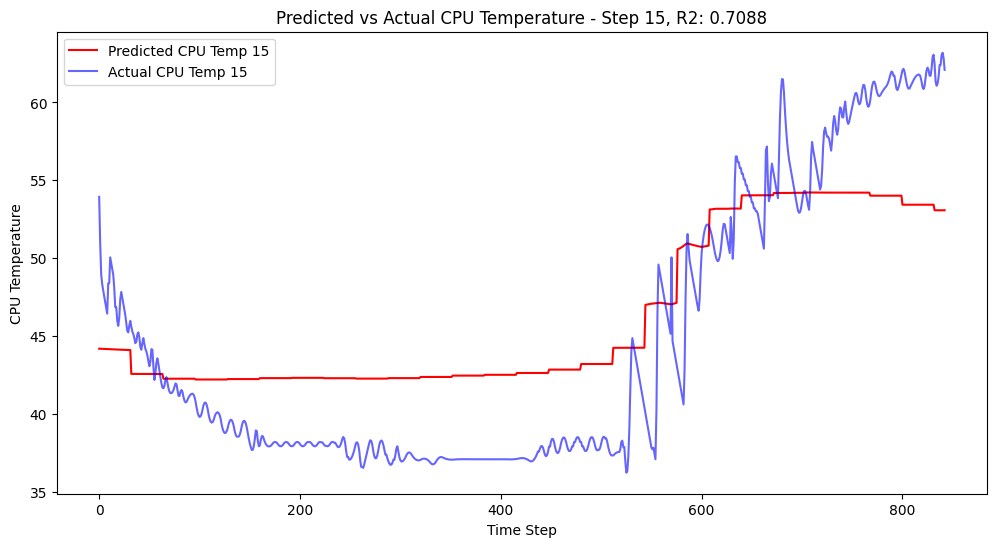

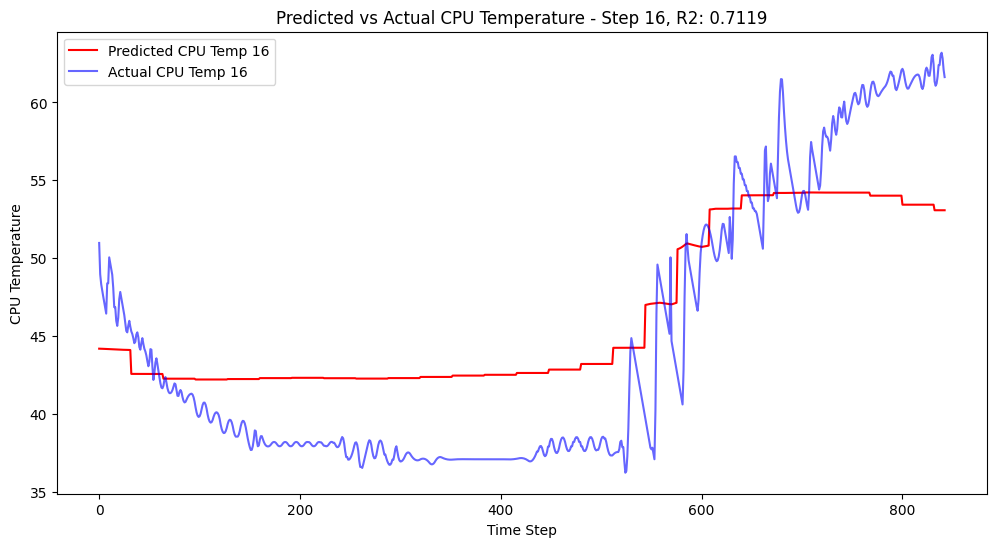

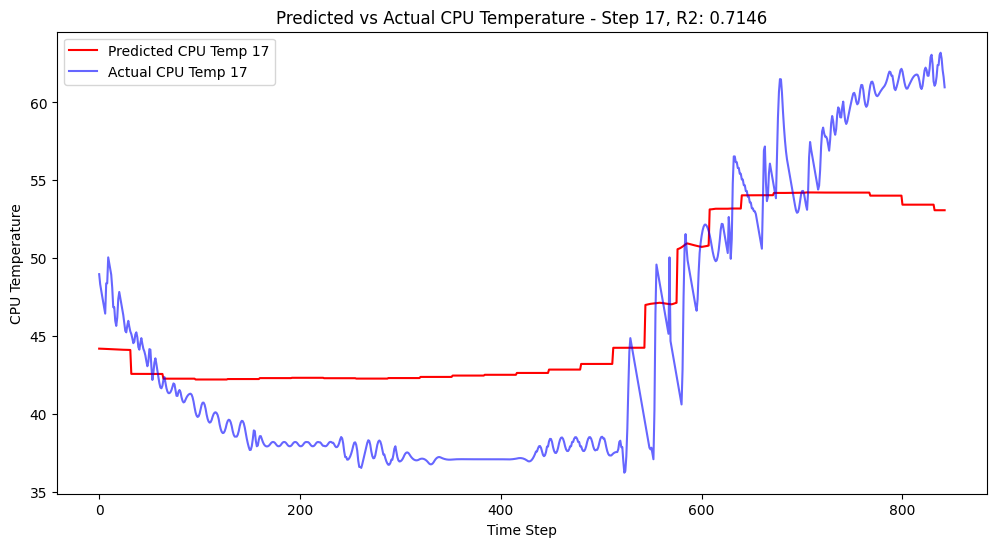

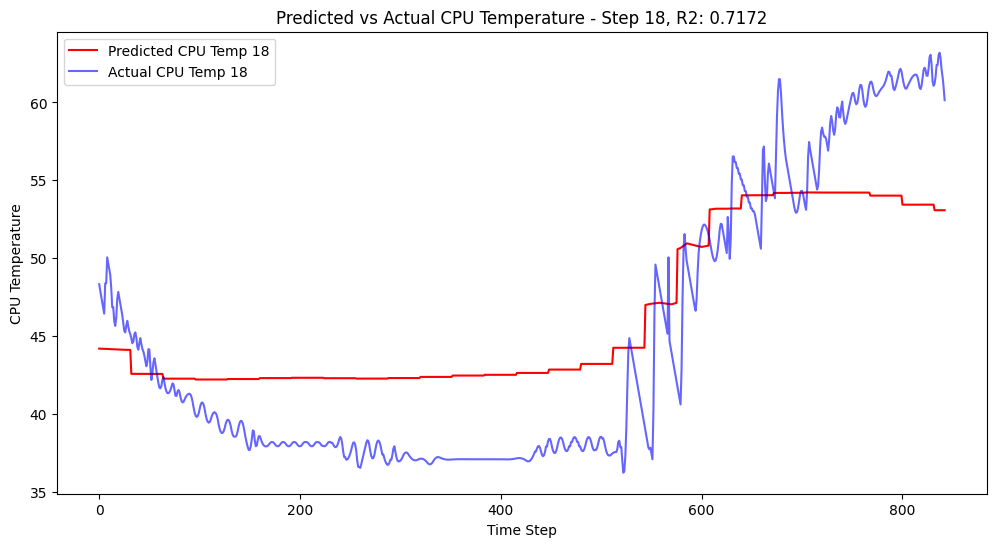

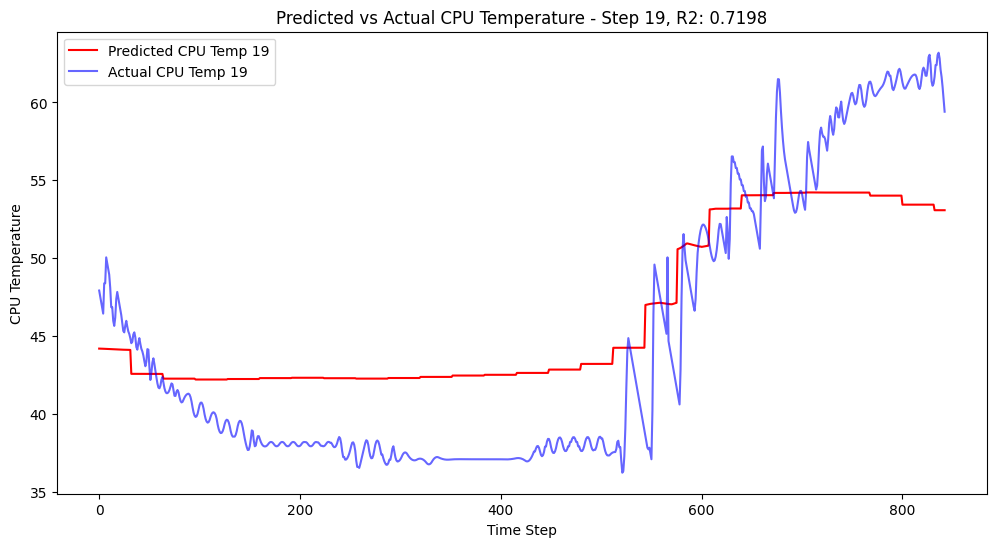

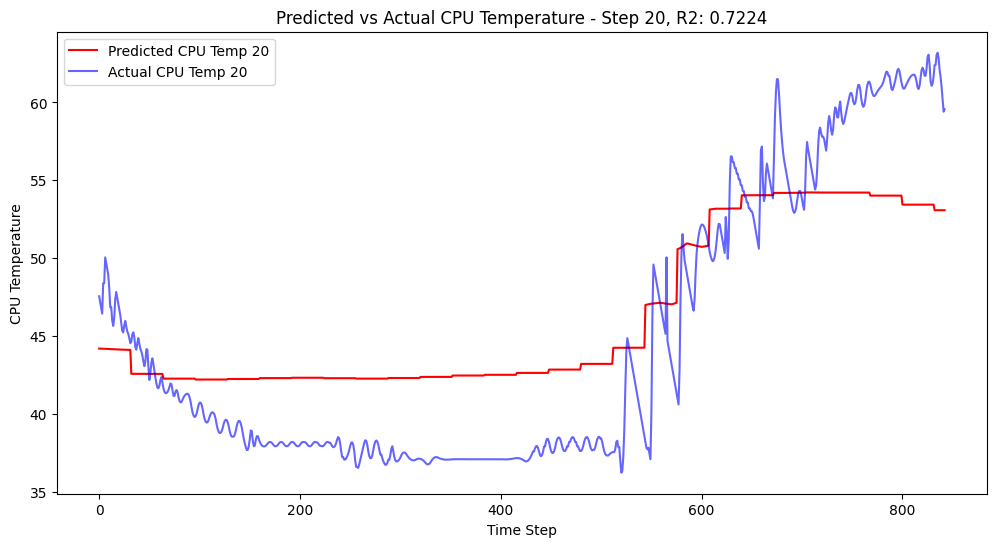

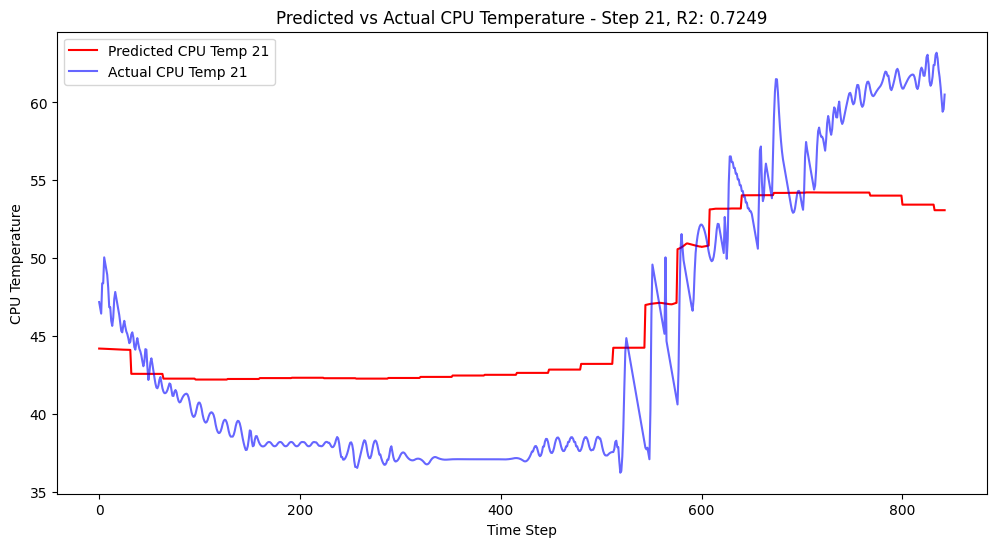

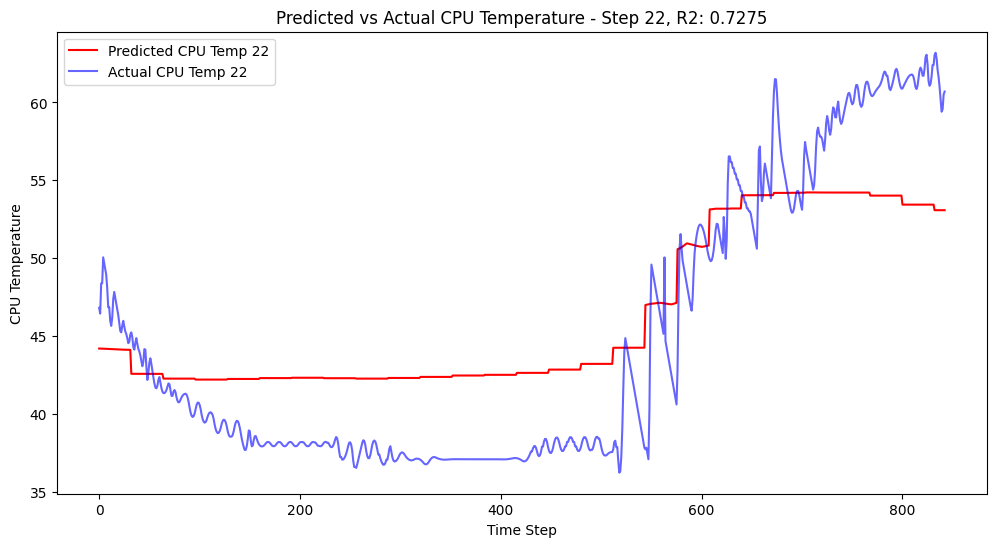

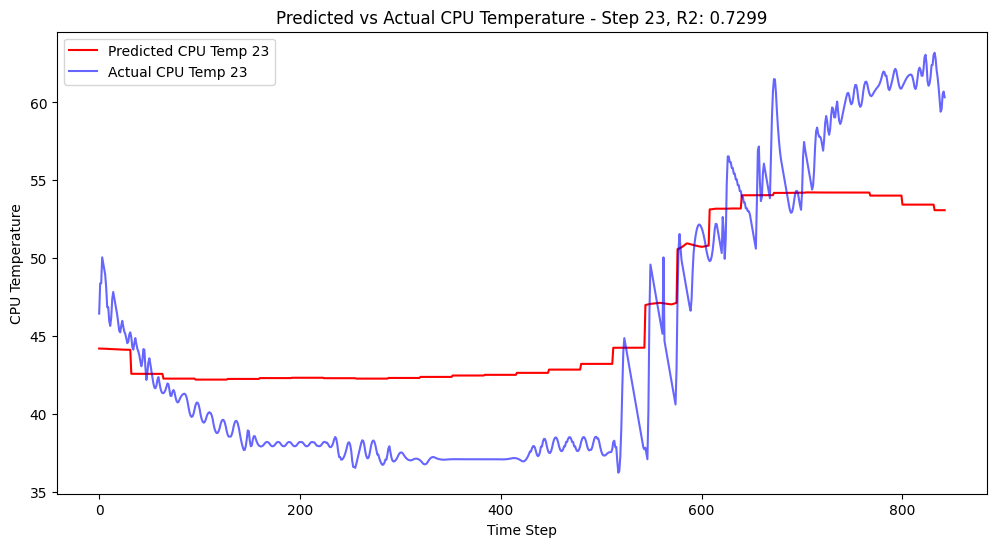

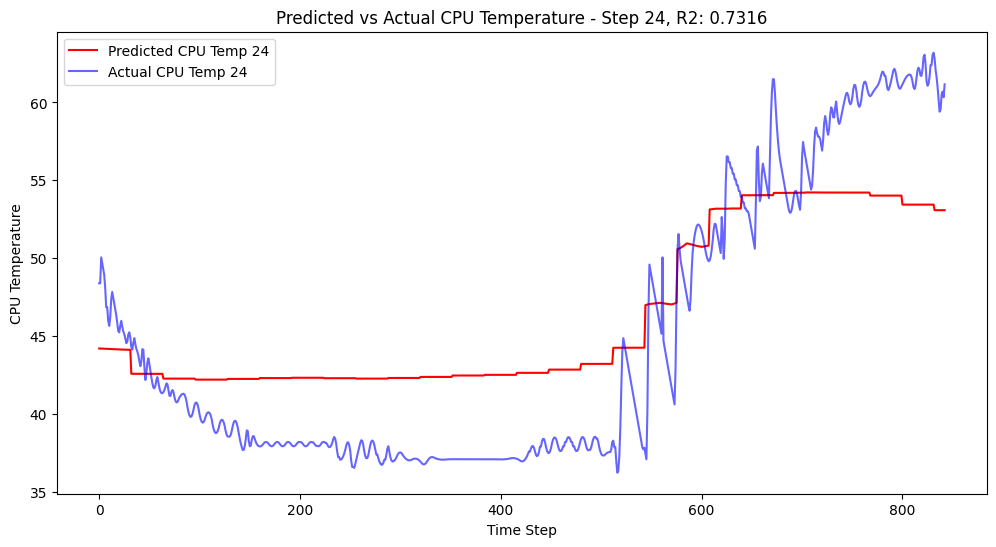

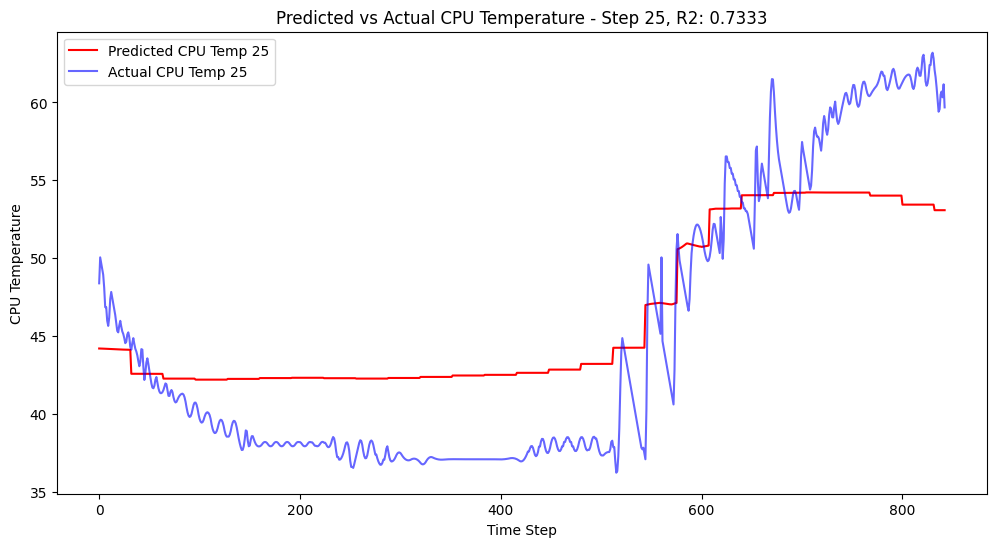

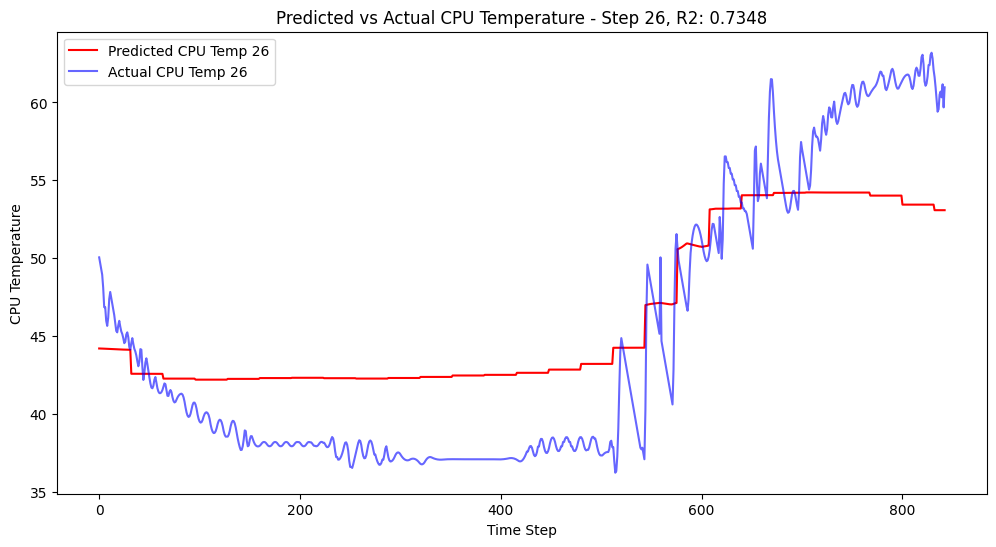

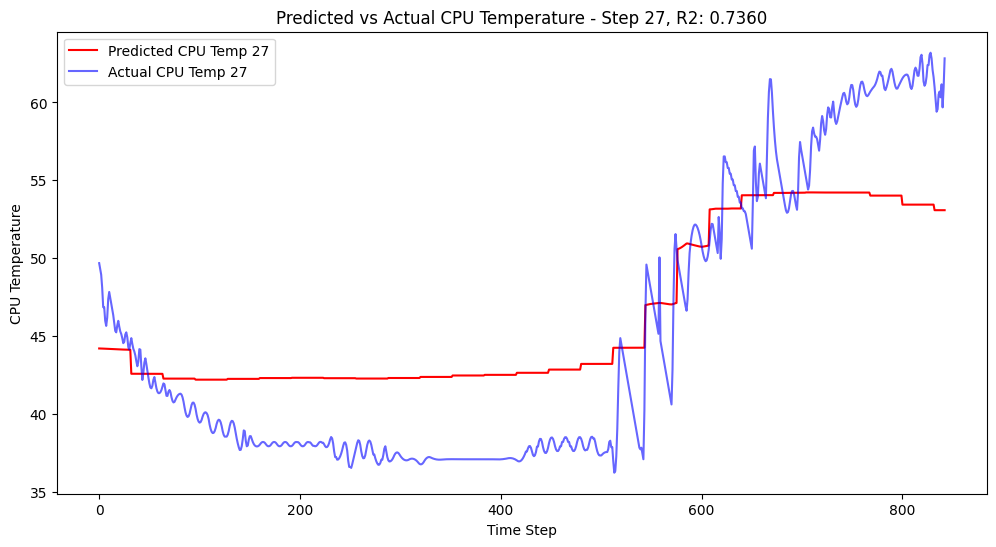

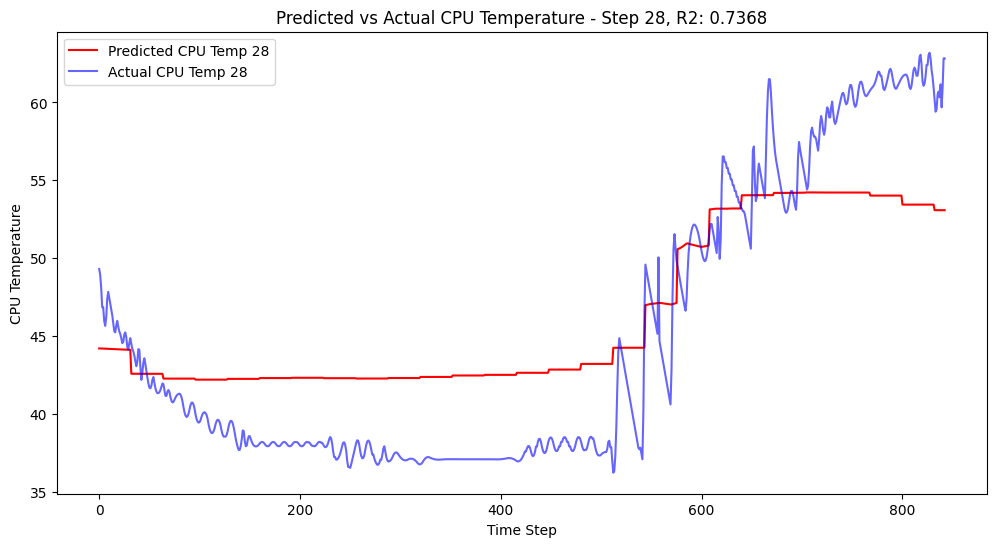

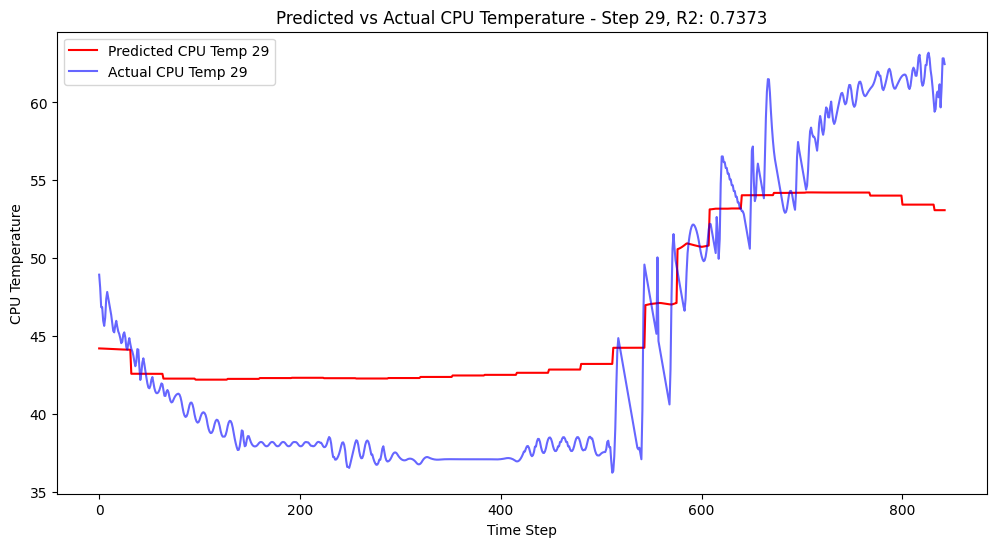

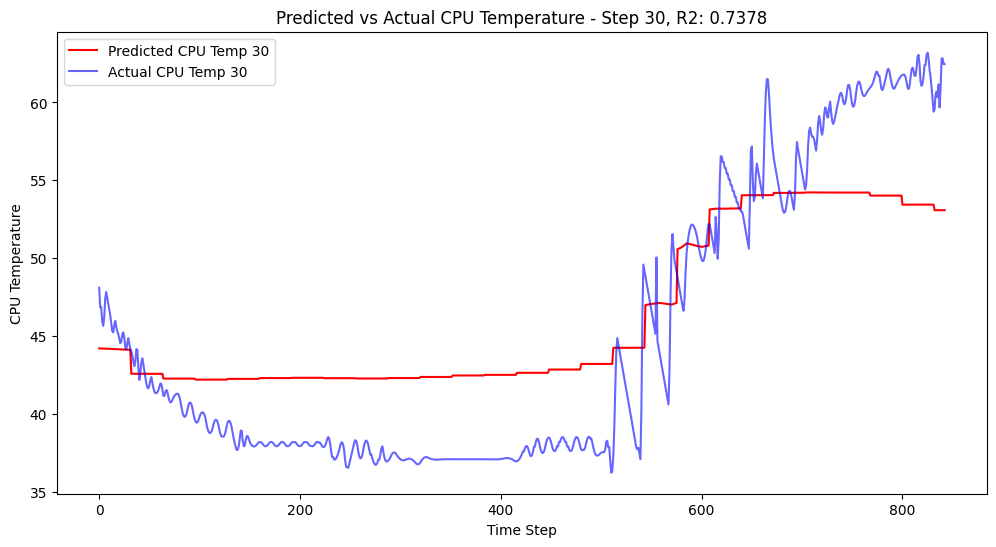

In [149]:
plot_results(predictions_df, k, r2_scores)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class TimeSeriesModelDecoder(nn.Module):
    def __init__(self, num_features_history, hidden_dim, num_features_future, future_dim, fusion_dim, k,
                 decoder_hidden_dim, teacher_forcing_ratio=0.5):
        super(TimeSeriesModelDecoder, self).__init__()

        self.k = k
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.num_features_future = num_features_future # save the future feature dimension

        # --- Encoder Block (History Processing) ---
        self.history_embedding = nn.Linear(num_features_history, hidden_dim)
        self.history_attention = nn.MultiheadAttention(hidden_dim, num_heads=1)
        self.history_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.history_pooling = nn.AdaptiveAvgPool1d(1)

        # --- Encoder Block (Future Processing) ---
        self.future_embedding = nn.Linear(num_features_future, future_dim)
        self.future_lstm = nn.LSTM(future_dim, future_dim, batch_first=True)
        self.future_attention = nn.MultiheadAttention(future_dim, num_heads=1)

        # --- Fusion Layer ---
        self.repeat_layer = lambda x, k: x.repeat(1, k, 1)
        self.fusion_dense1 = nn.Linear(hidden_dim, fusion_dim)
        self.fusion_dense2 = nn.Linear(future_dim, fusion_dim)
        self.fusion_attention = nn.MultiheadAttention(fusion_dim, num_heads=1)
        self.fusion_final = nn.Linear(2 * fusion_dim, fusion_dim)
        
        # --- Decoder Block ---
        self.decoder_lstm = nn.LSTM(fusion_dim, decoder_hidden_dim, batch_first=True)
        self.decoder_output = nn.Linear(decoder_hidden_dim, 1)  # Output is single value for each step

    def forward(self, X_history, Y_future):
         # --- Time Series History Processing Block ---
        # Input X_history : (batch_size, m, num_features_history)
        
        batch_size = X_history.size(0)
        
        embedded_history = F.relu(self.history_embedding(X_history))  # (batch_size, m, hidden_dim)
        
        # Attention Layer
        attn_output, _ = self.history_attention(embedded_history, embedded_history, embedded_history) #(batch_size, m, hidden_dim)

        lstm_output, _ = self.history_lstm(attn_output) # (batch_size, m, hidden_dim)

        pooled_history = self.history_pooling(lstm_output.permute(0, 2, 1)).permute(0,2,1) # (batch_size, 1, hidden_dim)
        
        # --- Time Series Future Processing Block ---
        # Input Y_future : (batch_size, k, num_features_future)
        
        embedded_future = F.relu(self.future_embedding(Y_future)) #(batch_size, k, future_dim)
        
        future_lstm_output, _ = self.future_lstm(embedded_future) # (batch_size, k, future_dim)
        
        future_attn_output, _ = self.future_attention(future_lstm_output, future_lstm_output, future_lstm_output) # (batch_size, k, future_dim)
        
        # --- Fusion Layer ---
        
        repeated_history = self.repeat_layer(pooled_history, self.k)  #(batch_size, k, hidden_dim)
        
        
        transformed_history = F.relu(self.fusion_dense1(repeated_history)) # (batch_size, k, fusion_dim)
        transformed_future = F.relu(self.fusion_dense2(future_attn_output)) # (batch_size, k, fusion_dim)
        
        combined_inputs = torch.cat((transformed_history, transformed_future), dim=-1) # (batch_size, k, 2*fusion_dim)
        fused_output = F.relu(self.fusion_final(combined_inputs)) #(batch_size, k, fusion_dim)
        
        # --- Decoder Block ---
        # fused_output shape (batch_size, k, fusion_dim)
        decoder_output, _ = self.decoder_lstm(fused_output) # (batch_size, k, decoder_hidden_dim)
        predictions = self.decoder_output(decoder_output) # (batch_size, k, 1)

        return predictions


    def predict(self, X_history, initial_future_input):
        # --- Time Series History Processing Block ---
        # Input X_history : (batch_size, m, num_features_history)
        
        batch_size = X_history.size(0)
        
        embedded_history = F.relu(self.history_embedding(X_history))  # (batch_size, m, hidden_dim)
        
        # Attention Layer
        attn_output, _ = self.history_attention(embedded_history, embedded_history, embedded_history) #(batch_size, m, hidden_dim)

        lstm_output, _ = self.history_lstm(attn_output) # (batch_size, m, hidden_dim)

        pooled_history = self.history_pooling(lstm_output.permute(0, 2, 1)).permute(0,2,1) # (batch_size, 1, hidden_dim)
        
        
        # --- Initialize Predictions ---
        predictions = []
        
        current_future_input = initial_future_input # (batch_size, 1, num_features_future)

         # --- Decoder Block (Generate k future predictions) ---
        for i in range(self.k):

            # --- Time Series Future Processing Block ---
            embedded_future = F.relu(self.future_embedding(current_future_input))  # (batch_size, 1, future_dim)
            future_lstm_output, _ = self.future_lstm(embedded_future)  # (batch_size, 1, future_dim)
            future_attn_output, _ = self.future_attention(future_lstm_output, future_lstm_output, future_lstm_output)

            # --- Fusion Layer ---
            repeated_history = self.repeat_layer(pooled_history, 1)  # (batch_size, 1, hidden_dim)

            transformed_history = F.relu(self.fusion_dense1(repeated_history))  # (batch_size, 1, fusion_dim)
            transformed_future = F.relu(self.fusion_dense2(future_attn_output))  # (batch_size, 1, fusion_dim)

            combined_inputs = torch.cat((transformed_history, transformed_future), dim=-1)  # (batch_size, 1, 2*fusion_dim)
            fused_output = F.relu(self.fusion_final(combined_inputs)) # (batch_size, 1, fusion_dim)

            # --- Decoder Block (single step) ---
            decoder_output, _ = self.decoder_lstm(fused_output)  # (batch_size, 1, decoder_hidden_dim)
            prediction = self.decoder_output(decoder_output)  # (batch_size, 1, 1)
            predictions.append(prediction)

            #Update current input for the decoder using the predicted value
            current_future_input = prediction.detach()
            
        # Concatenate all predictions
        predictions = torch.cat(predictions, dim=1)  # (batch_size, k, 1)
        
        return predictions

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001, device='cpu'):
    """
    Trains the TimeSeriesModelDecoder.

    Args:
        model (nn.Module): The TimeSeriesModelDecoder instance.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        device (str): 'cpu' or 'cuda' to use for training.

    Returns:
        None (or you can modify to return training statistics/model checkpoint)
    """
    model.to(device) #Move the model to the device being used for training (CPU or GPU)

    criterion = nn.MSELoss()  # Mean Squared Error Loss (or any other appropriate loss)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) #Adam optimizer, you can use any optimizer that is suited for your problem

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0
        
        for batch_idx, (batch_features, batch_exogenous, batch_outputs) in enumerate(train_loader):
            batch_features = batch_features.to(device)  #Move data to the device used for training
            batch_exogenous = batch_exogenous.to(device) #Move data to the device used for training
            batch_outputs = batch_outputs.to(device)    #Move data to the device used for training

            optimizer.zero_grad()  # Clear gradients from previous steps
            predictions = model(batch_features, batch_exogenous)  # Forward pass
            loss = criterion(predictions, batch_outputs)  # Compute loss

            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step() # Update the weights

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Evaluation on test set (optional)
        model.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for batch_idx, (batch_features, batch_exogenous, batch_outputs) in enumerate(test_loader):
                batch_features = batch_features.to(device) # Move data to the device used for training
                batch_exogenous = batch_exogenous.to(device) # Move data to the device used for training
                batch_outputs = batch_outputs.to(device)   # Move data to the device used for training
                
                # Use the predict function for inference
                initial_future_input = batch_exogenous[:, 0, :].unsqueeze(1)  # Initial input from future data
                test_predictions = model.predict(batch_features, initial_future_input) # make predictions with predict, with initial future input

                test_loss = criterion(test_predictions, batch_outputs)

                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)

        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    print("Training complete.")
    return model

In [60]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader


def evaluate_model(model, test_loader, scaler, df, k_step, outputs, split_index, device='cpu', num_features_future=1):
    """
    Evaluates the TimeSeriesModelDecoder and calculates performance metrics.

    Args:
        model (nn.Module): The trained TimeSeriesModelDecoder.
        test_loader (DataLoader): DataLoader for test data.
        scaler (MinMaxScaler): Scaler used for original data scaling
        df (pd.DataFrame): original Pandas DataFrame
        k_step (int): Number of future steps predicted.
        outputs: Tensor of all the labels
        split_index: The index at which the dataset is split to train and test
        device (str): 'cpu' or 'cuda' to use for evaluation.
        num_features_future: number of features for the future input

    Returns:
       predictions_df (pd.DataFrame): Dataframe containing the actual and predicted values for every step in the k_step range
       test_loss (float): Test loss.
       r2_scores (List[float]): R2 score for every step in the k_step range
       rmse_scores (List[float]): RMSE score for every step in the k_step range
       average_r2 (float): Average R2 score.
       average_rmse (float): Average RMSE score.
    """
    model.to(device)  # Move model to device for evaluation
    model.eval()  # Sets the model to evaluation mode
    criterion = nn.MSELoss()  # Initialize loss function
    test_loss = 0.0  # Initialize test_loss
    predictions = []  # Store model predictions
    actuals = []  # Store actual labels

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            batch_features = batch_features.to(device)  # Move input to device
            batch_exogenous = batch_exogenous.to(device)  # Move input to device
            batch_outputs = batch_outputs.to(device)    # Move labels to device

            # Make predictions using the predict method
            initial_future_input = batch_exogenous[:, 0, :].unsqueeze(1)
            batch_predictions = model.predict(batch_features, initial_future_input) # call the predict method to get output
            
            loss = criterion(batch_predictions, batch_outputs)  # Calculate the loss
            test_loss += loss.item()
            predictions.append(batch_predictions.cpu().numpy())  # Save predictions to numpy, and move to cpu
            actuals.append(batch_outputs.cpu().numpy())  # Save actual values to numpy and move to cpu

    test_loss /= len(test_loader)  # Calculates test loss
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy array and rescale
    predictions = np.concatenate(predictions, axis=0)  # Concatenate along the batches
    actuals = np.concatenate(actuals, axis=0)  # Concatenate along the batches

    # Create a dataframe using the original dataframe index and actual values
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i, 0]

    # Create a dataframe from predictions using the same index as the actual values
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:, i, 0]

    # Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values)
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]
    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")

    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse

In [62]:
num_features_history = 3
hidden_dim = 64
decoder_hidden = 64
num_features_future = 1
future_dim = 32
fusion_dim = 128

model = TimeSeriesModelDecoder(num_features_history, hidden_dim, num_features_future, future_dim, fusion_dim, k, decoder_hidden)

epochs = 20
learning_rate = 0.001
device = 'cpu'

trained_model = train_model(model, train_loader, test_loader, epochs, learning_rate, device)

Epoch: 1/20, Train Loss: 0.085808, Test Loss: 0.094248
Epoch: 2/20, Train Loss: 0.028775, Test Loss: 0.014827
Epoch: 3/20, Train Loss: 0.007123, Test Loss: 0.021831
Epoch: 4/20, Train Loss: 0.007826, Test Loss: 0.017647
Epoch: 5/20, Train Loss: 0.006764, Test Loss: 0.013176
Epoch: 6/20, Train Loss: 0.006421, Test Loss: 0.014297
Epoch: 7/20, Train Loss: 0.006644, Test Loss: 0.014351
Epoch: 8/20, Train Loss: 0.006465, Test Loss: 0.013123
Epoch: 9/20, Train Loss: 0.006158, Test Loss: 0.012661
Epoch: 10/20, Train Loss: 0.005992, Test Loss: 0.009979
Epoch: 11/20, Train Loss: 0.006382, Test Loss: 0.009591
Epoch: 12/20, Train Loss: 0.005912, Test Loss: 0.013502
Epoch: 13/20, Train Loss: 0.005331, Test Loss: 0.008679
Epoch: 14/20, Train Loss: 0.005426, Test Loss: 0.009678
Epoch: 15/20, Train Loss: 0.005654, Test Loss: 0.008394
Epoch: 16/20, Train Loss: 0.005875, Test Loss: 0.009412
Epoch: 17/20, Train Loss: 0.005503, Test Loss: 0.012357
Epoch: 18/20, Train Loss: 0.006318, Test Loss: 0.009281
E

In [63]:
predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(trained_model, test_loader, scalers["cpu_temp"], combined_df, k, outputs, split_index, device)

Test Loss: 0.0093
R2 Score for Step 1: 0.8866
R2 Score for Step 2: 0.8886
R2 Score for Step 3: 0.8899
R2 Score for Step 4: 0.8914
R2 Score for Step 5: 0.8930
R2 Score for Step 6: 0.8946
R2 Score for Step 7: 0.8959
R2 Score for Step 8: 0.8969
R2 Score for Step 9: 0.8973
R2 Score for Step 10: 0.8980
R2 Score for Step 11: 0.8990
R2 Score for Step 12: 0.8997
R2 Score for Step 13: 0.9005
R2 Score for Step 14: 0.9019
R2 Score for Step 15: 0.9032
R2 Score for Step 16: 0.9043
R2 Score for Step 17: 0.9053
R2 Score for Step 18: 0.9065
R2 Score for Step 19: 0.9077
R2 Score for Step 20: 0.9089
R2 Score for Step 21: 0.9102
R2 Score for Step 22: 0.9113
R2 Score for Step 23: 0.9120
R2 Score for Step 24: 0.9121
R2 Score for Step 25: 0.9122
R2 Score for Step 26: 0.9121
R2 Score for Step 27: 0.9113
R2 Score for Step 28: 0.9101
R2 Score for Step 29: 0.9090
R2 Score for Step 30: 0.9078
Average R2 Score: 0.9026
RMSE for Step 1: 2.8699
RMSE for Step 2: 2.8506
RMSE for Step 3: 2.8402
RMSE for Step 4: 2.8275


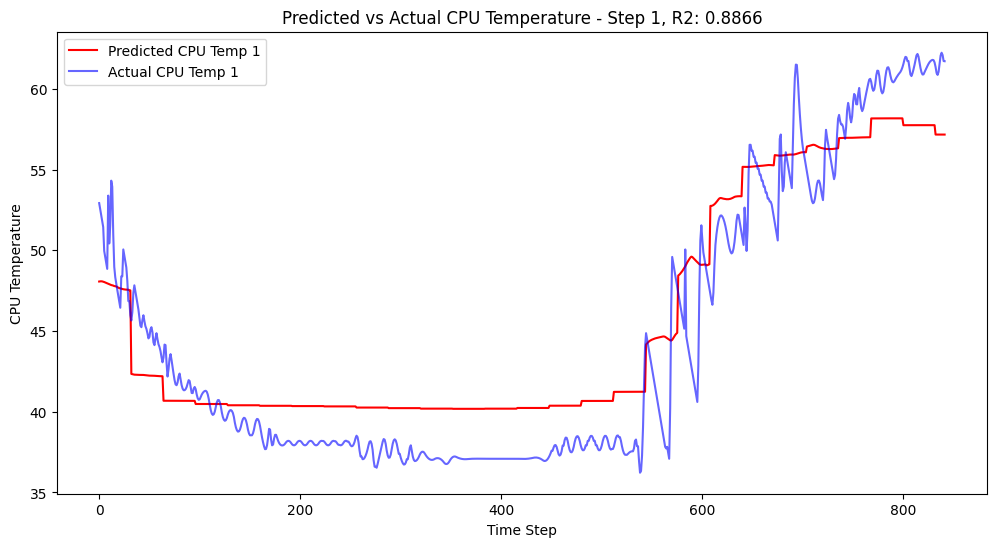

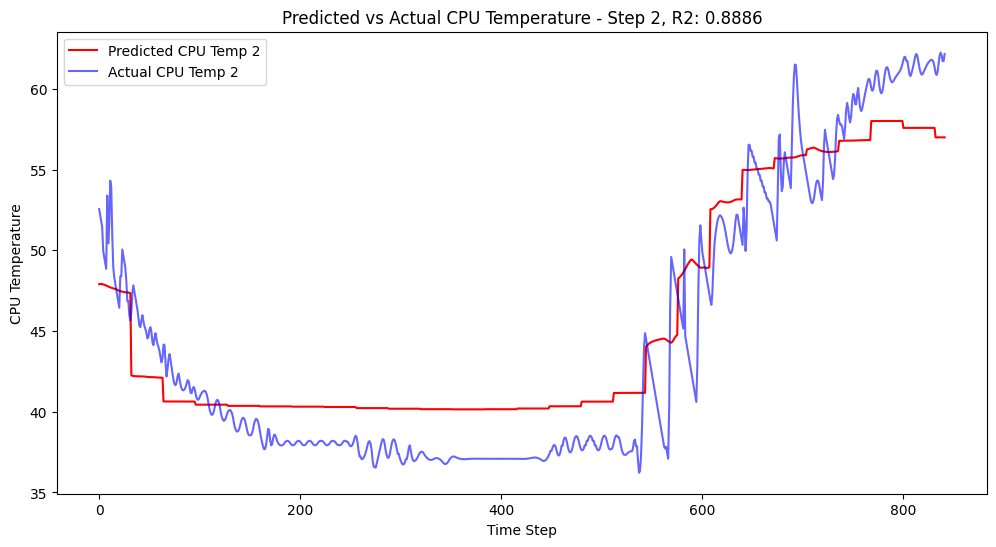

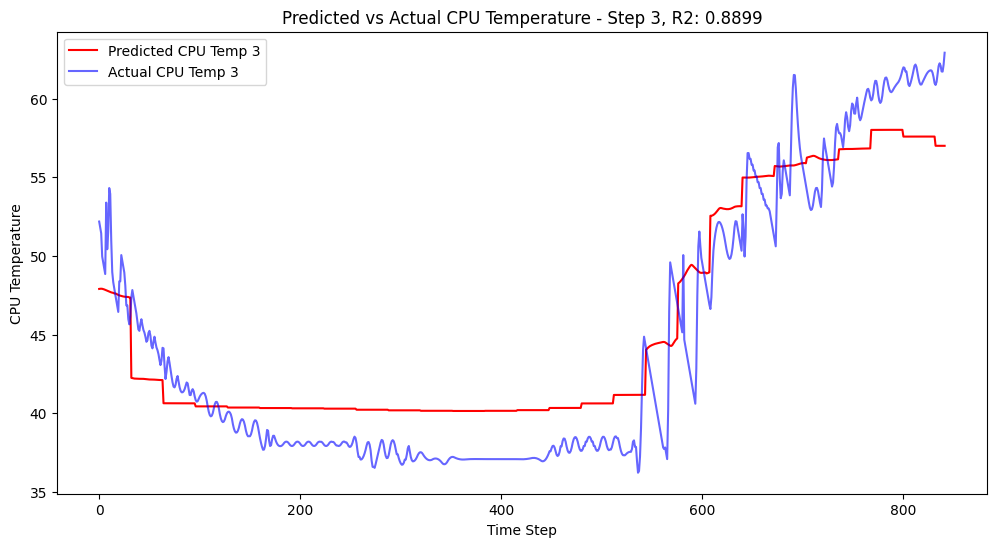

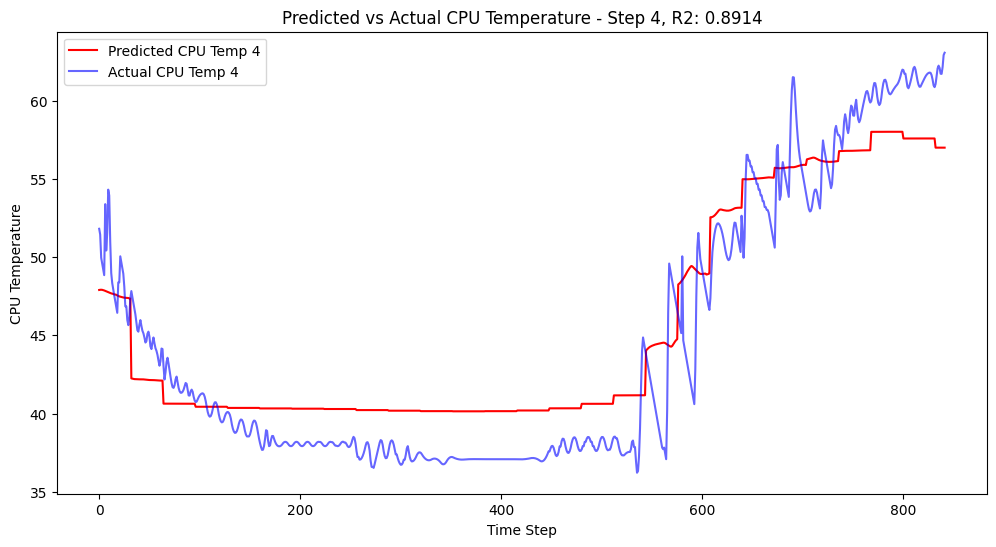

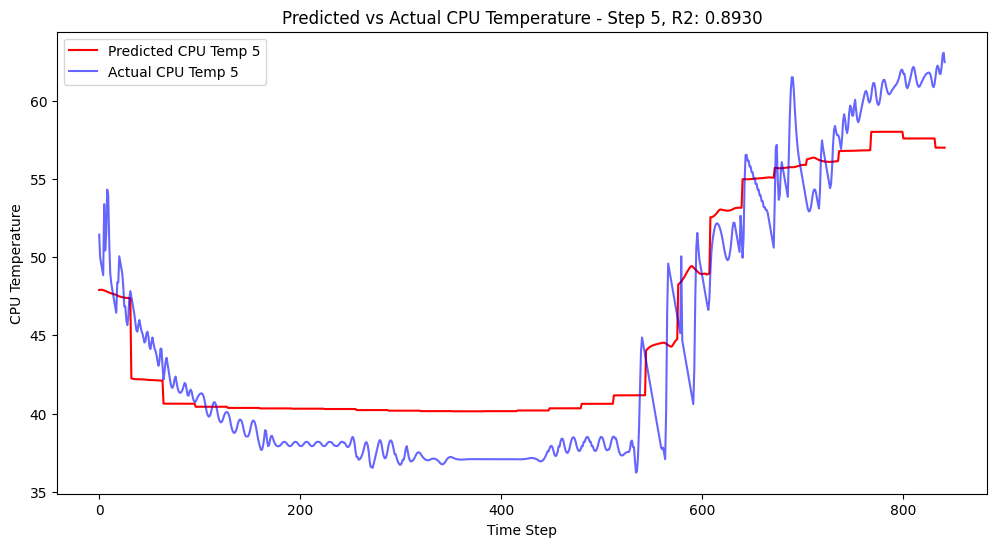

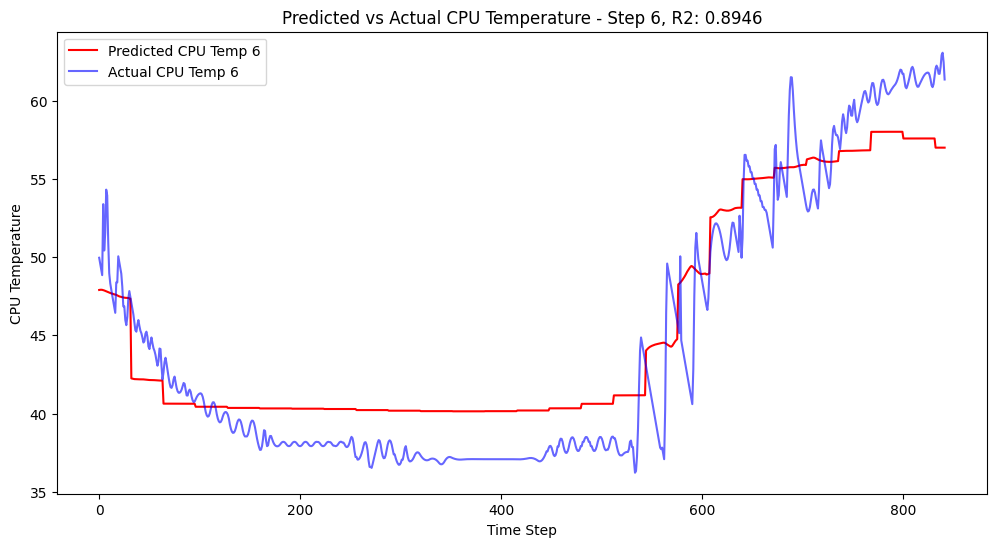

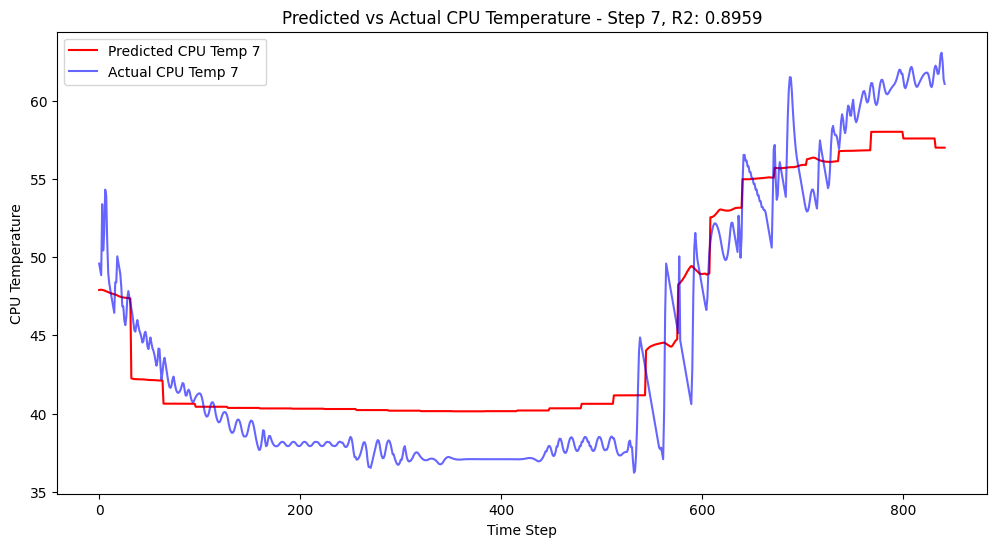

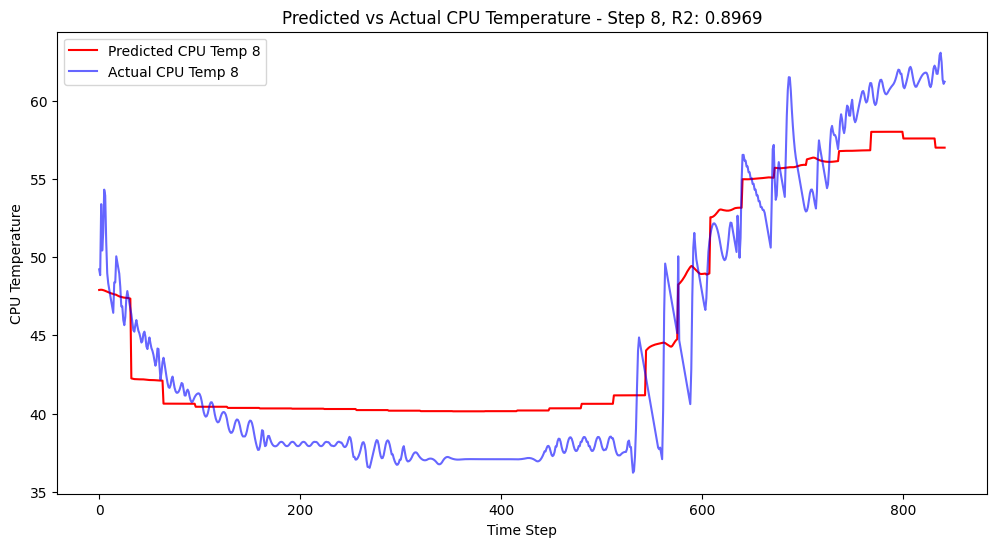

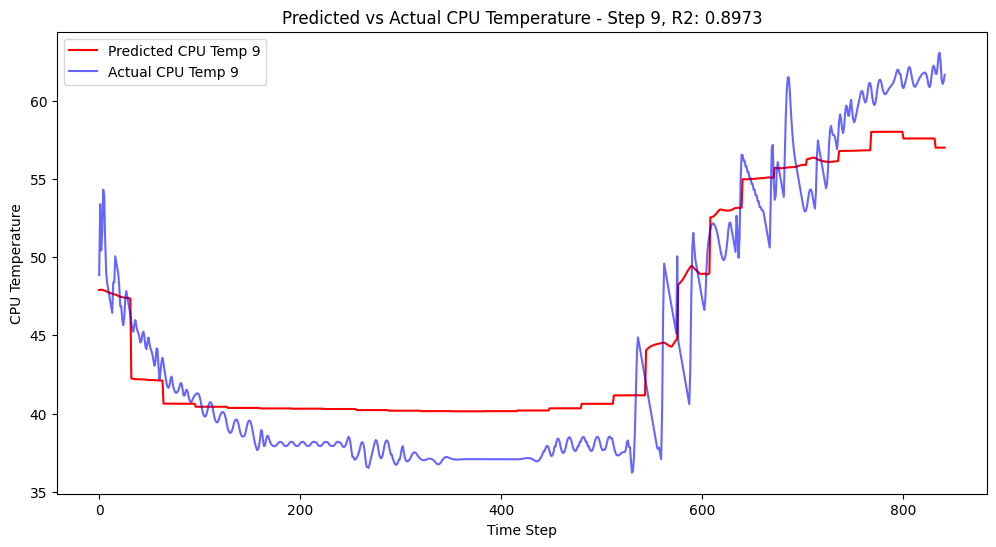

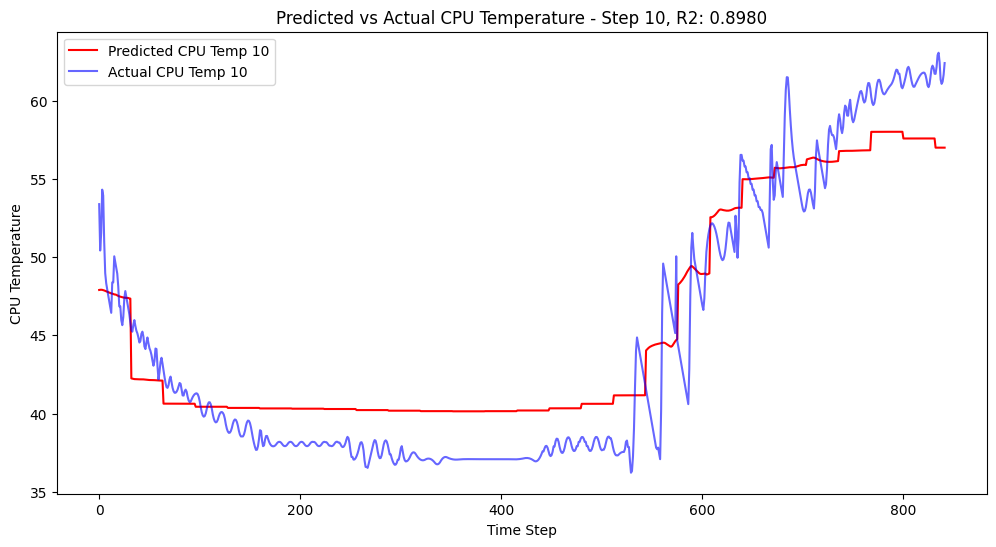

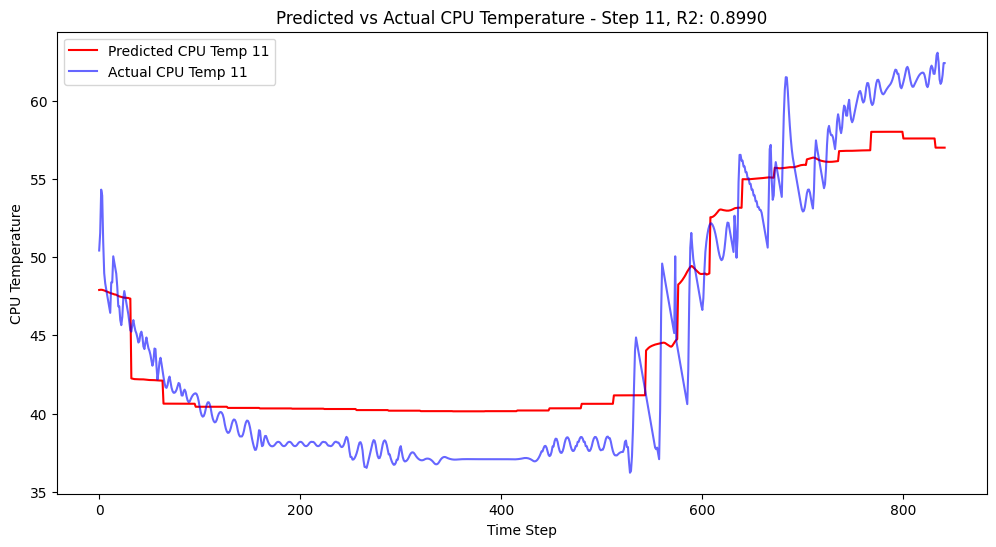

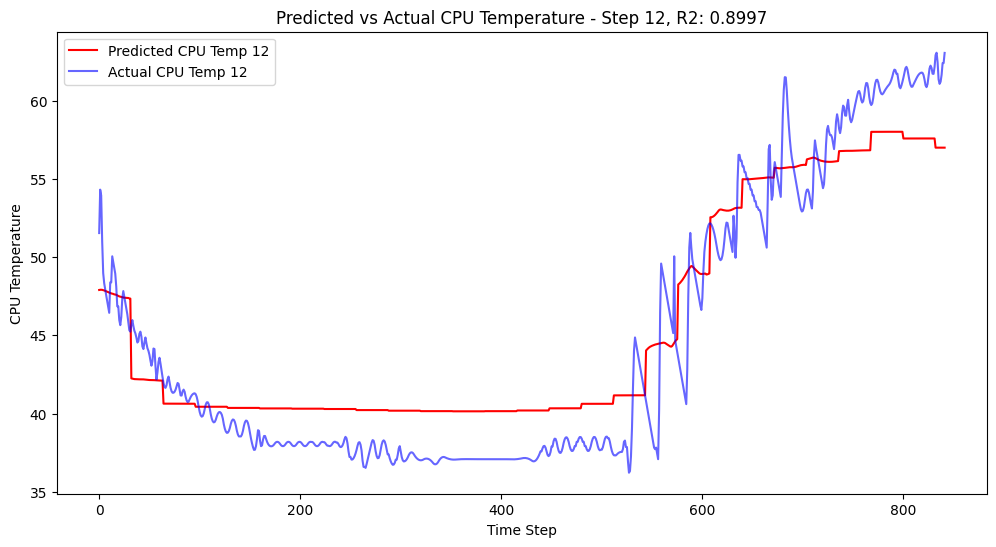

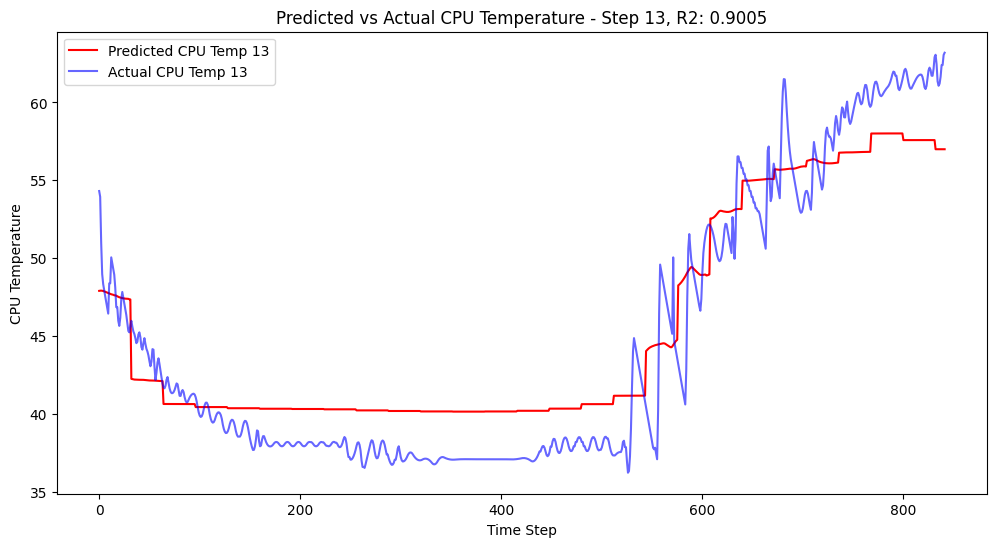

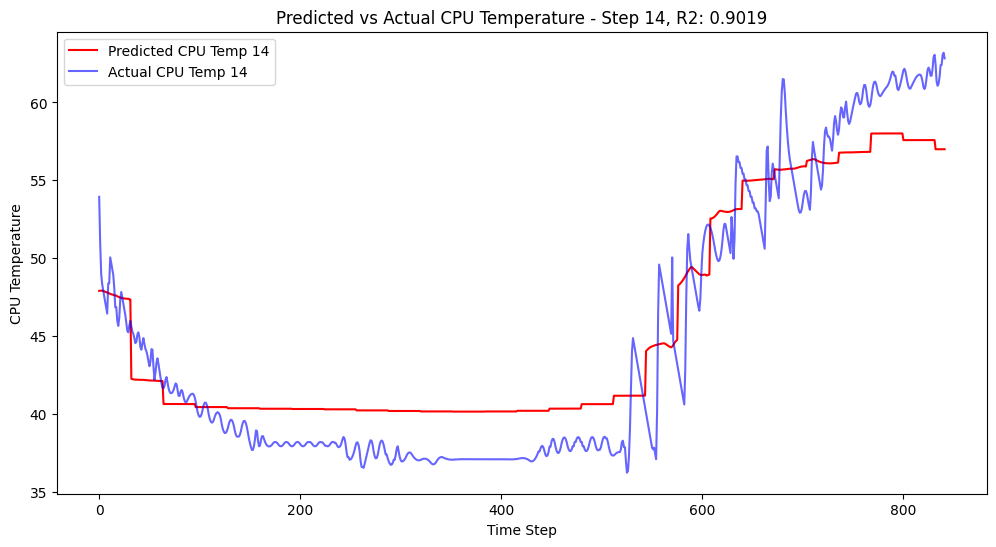

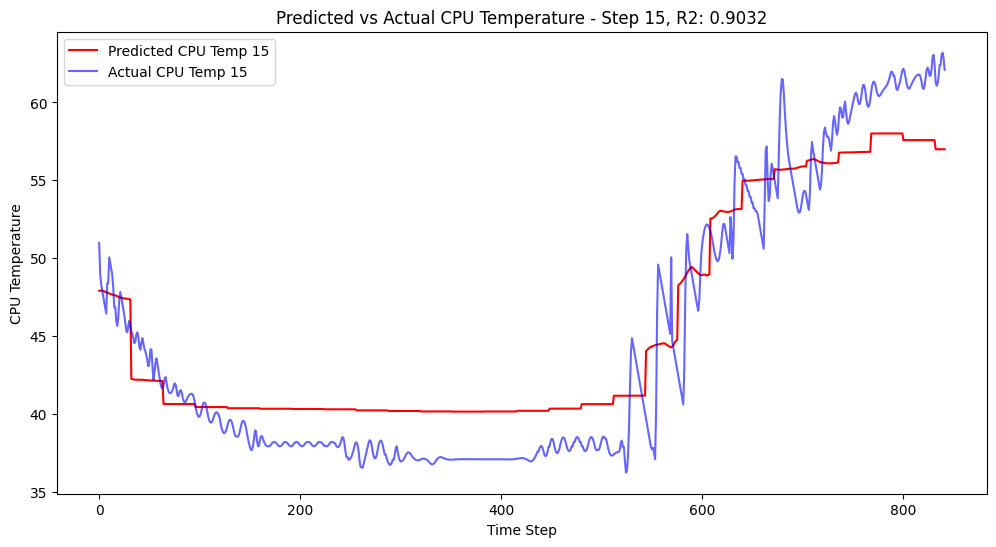

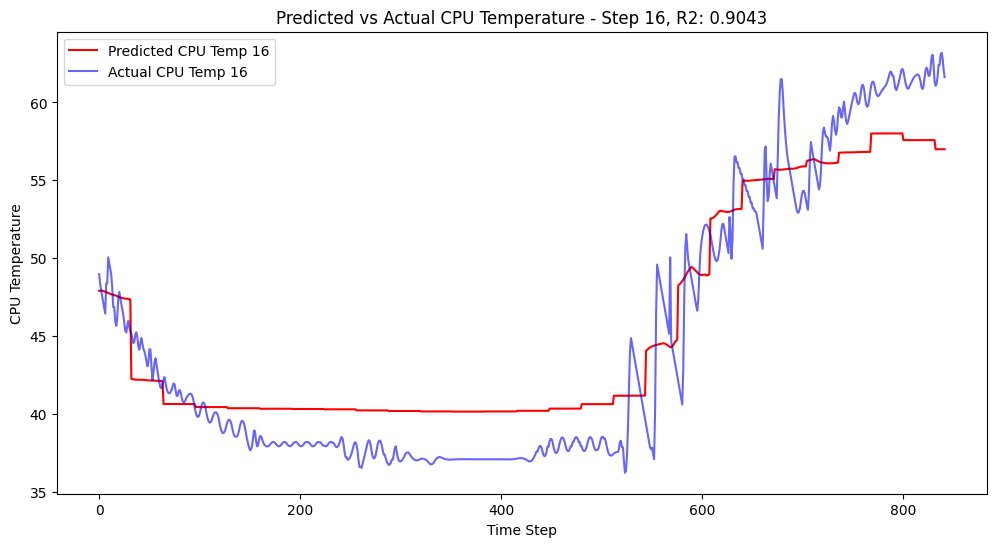

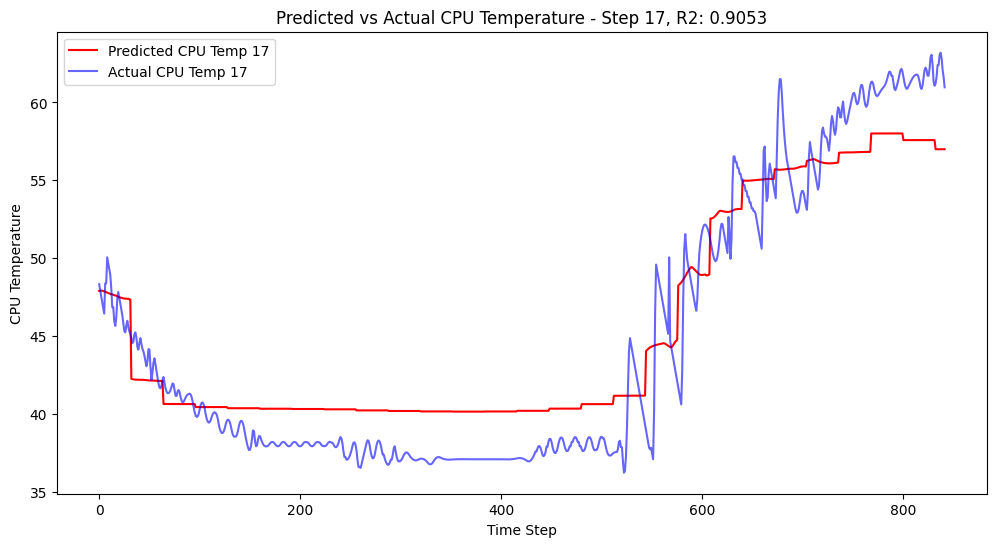

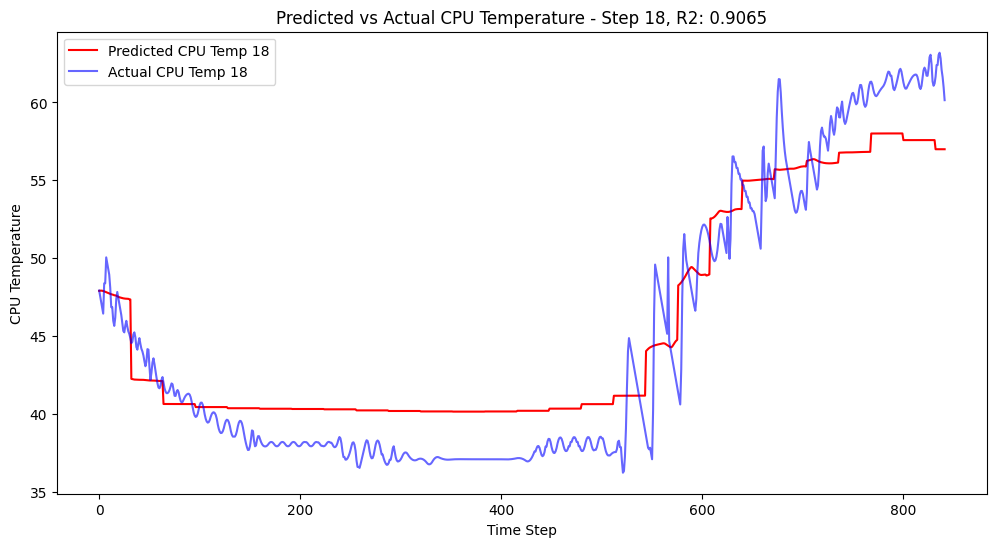

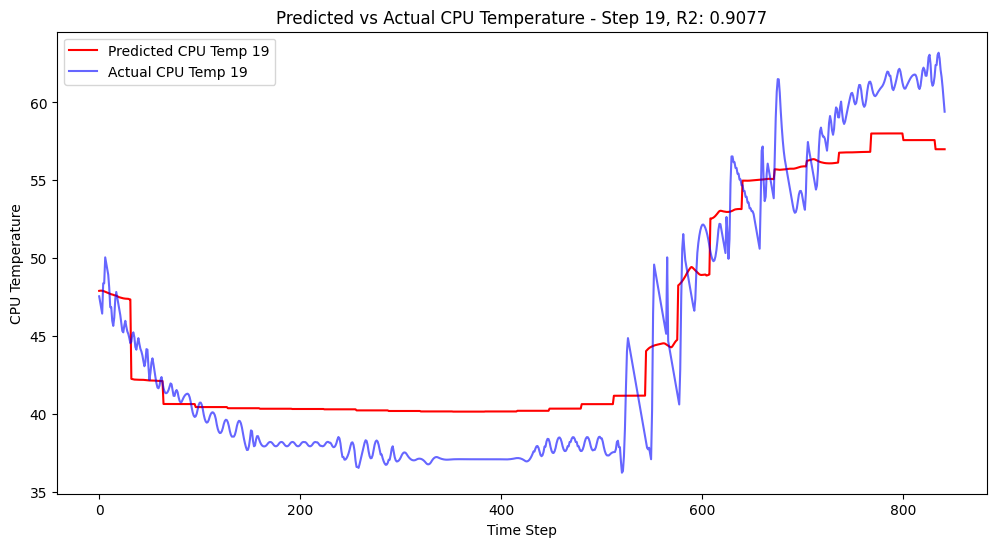

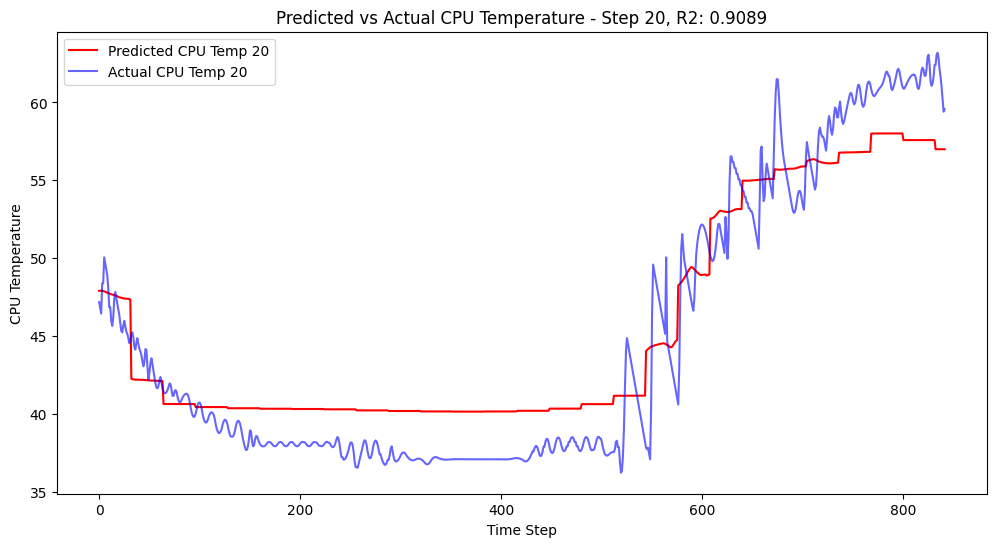

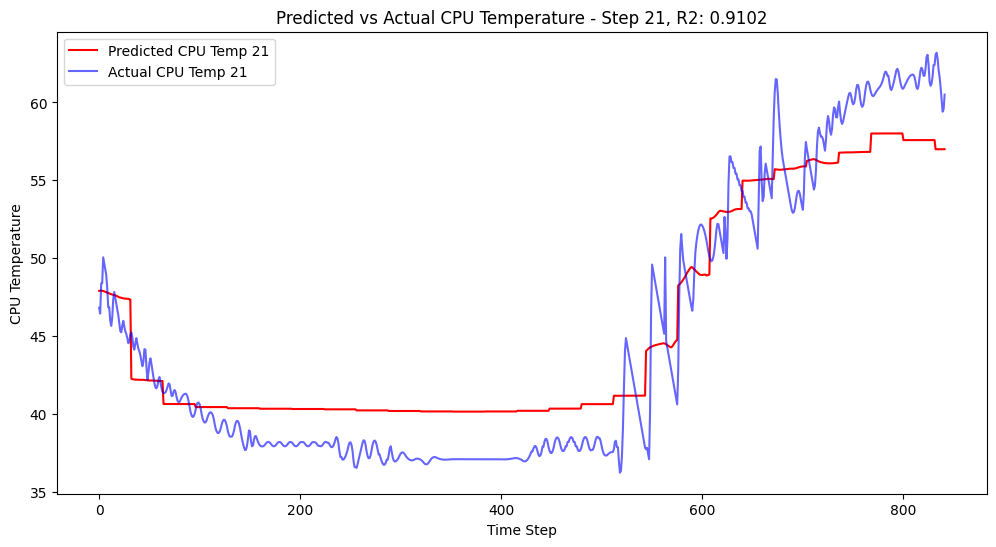

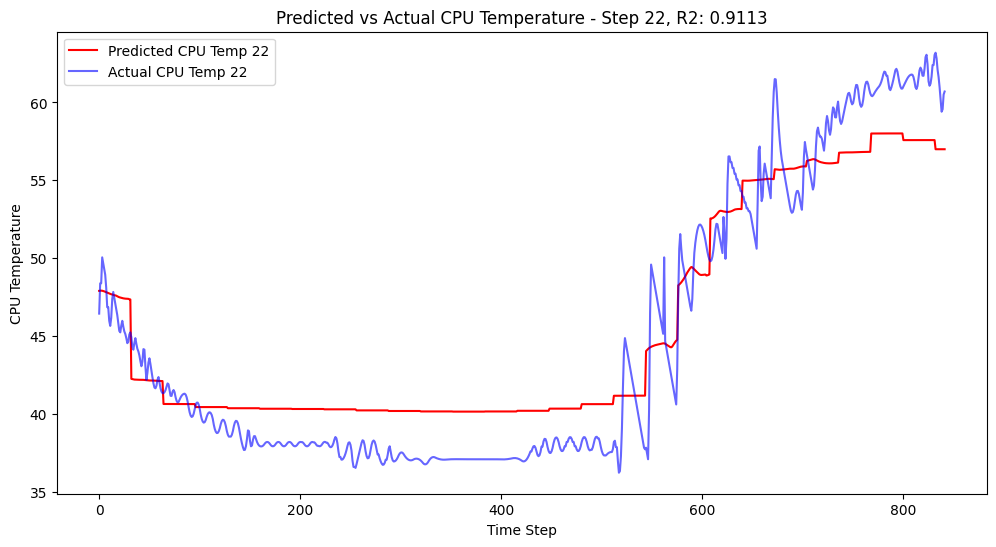

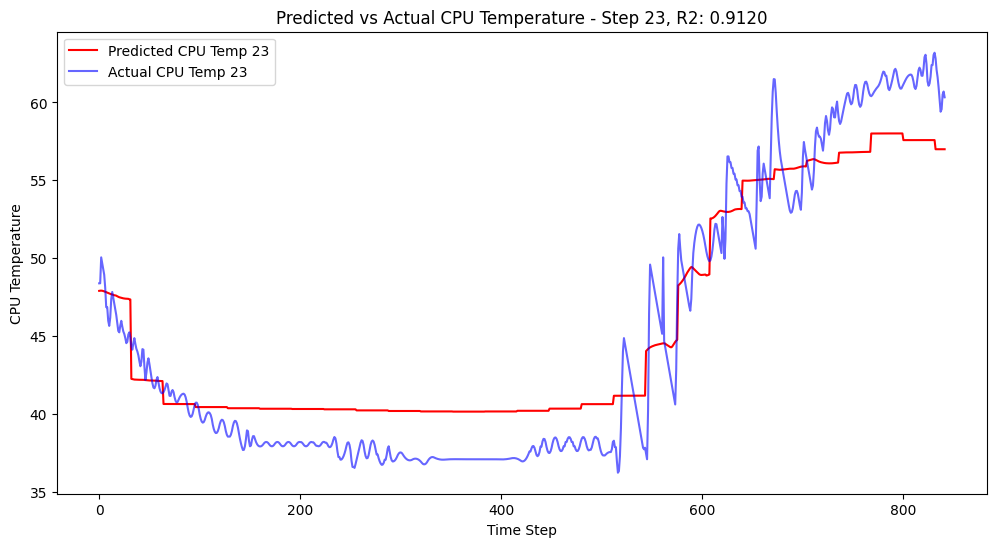

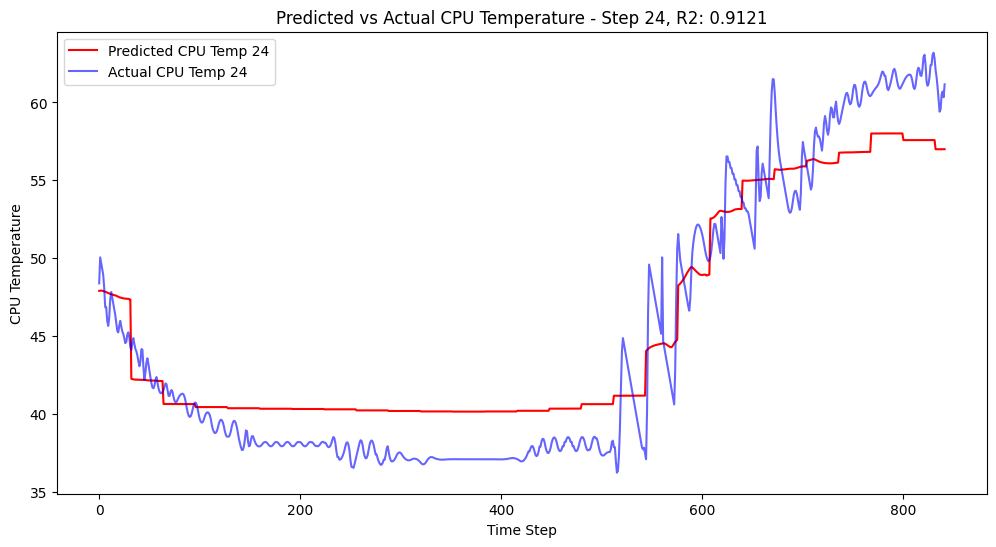

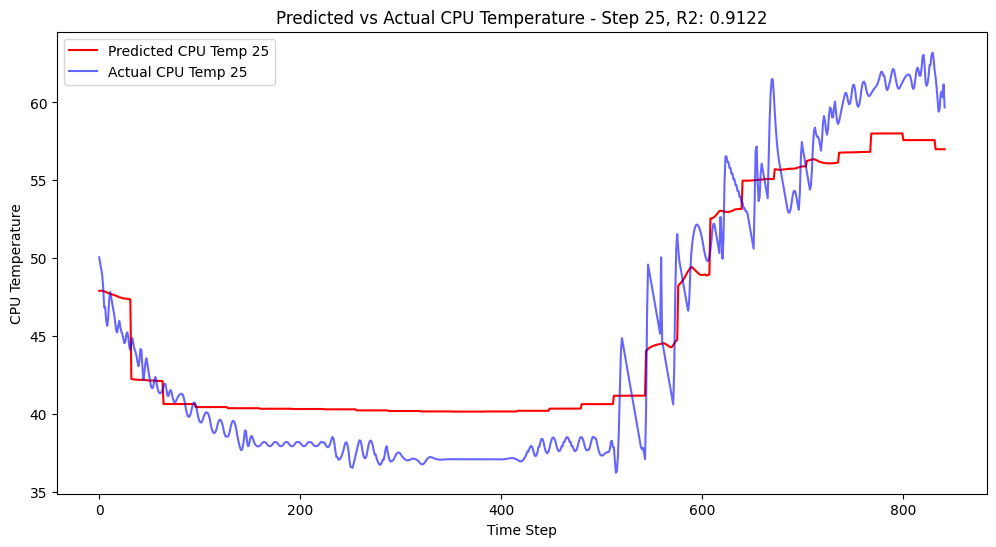

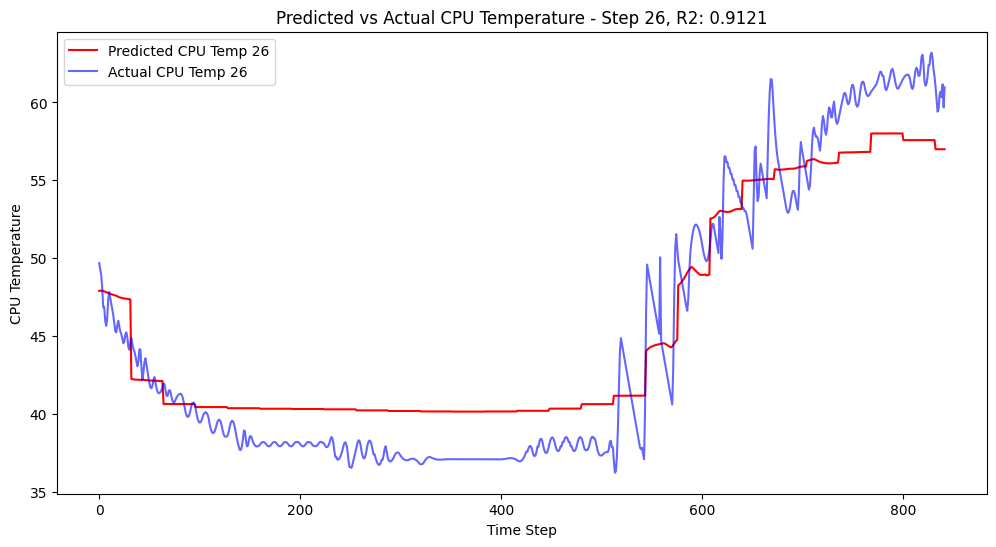

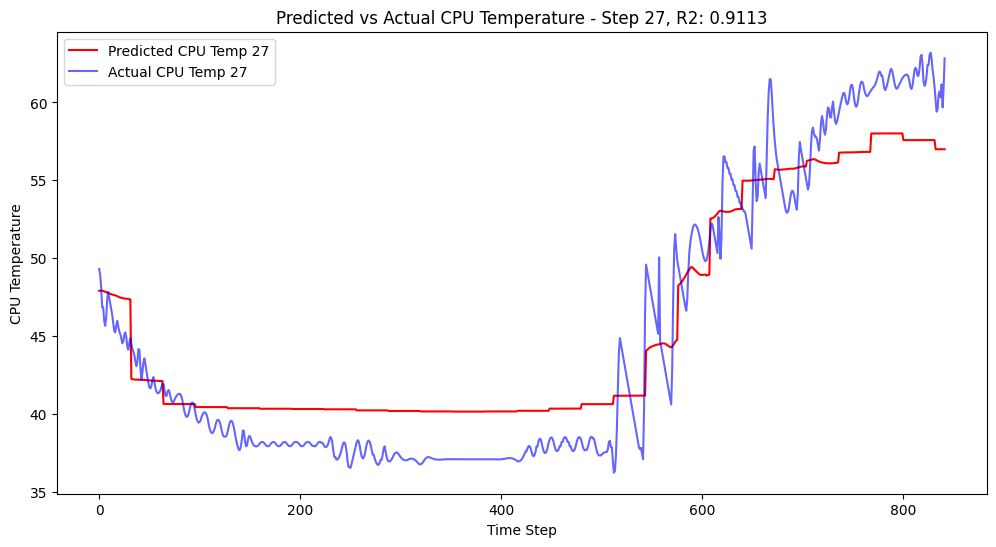

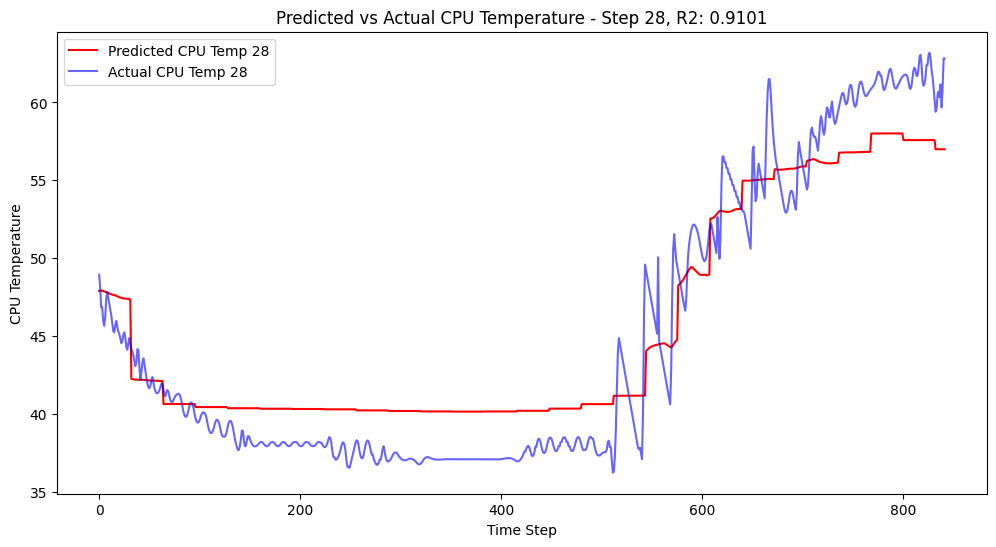

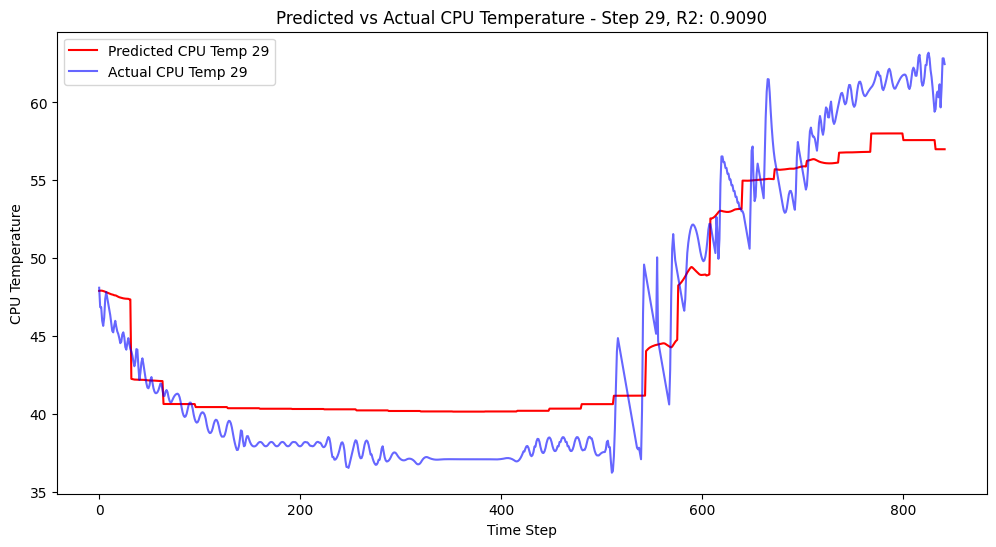

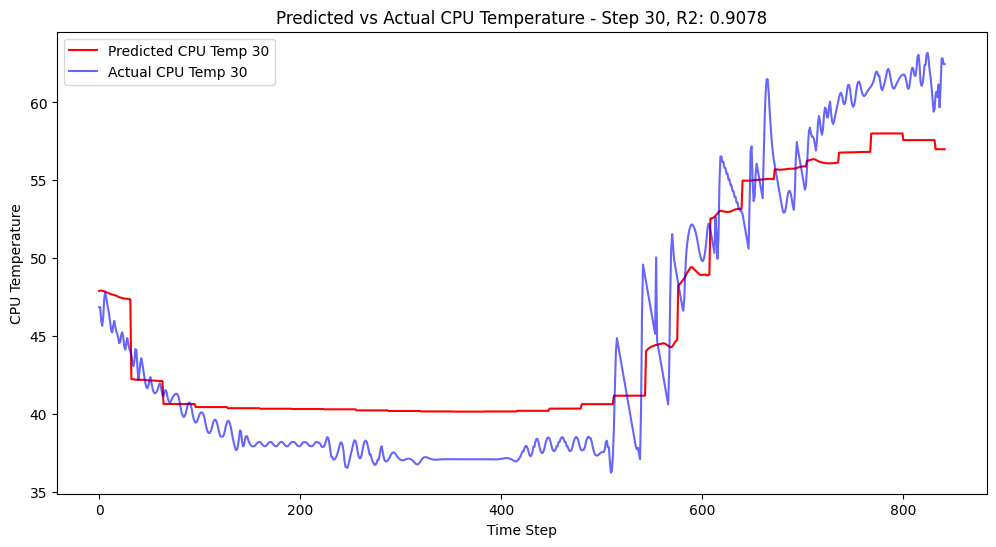

In [64]:
plot_results(predictions_df, k, r2_scores)